**Project context**

Stock Market: Several exchanges in which shares of publicly held companies are bought and sold.

Stock/Share/Equity:  Unit of ownership in a company. A stockholder have a claim on a portion of the company's assets and earnings, and is able to vote on certain company decisions. The value of a stock can fluctuate based on a variety of factors.

Investors can buy and sell stocks on stock exchanges, such as the NASDAQ, NYSE (New York Stock Exchange), Bolsa de Madrid, Bolsa de comercio de Buenos Aires (BCBA), etc., where the price of a stock is determined by the forces of supply and demand.

<p class="mx-auto" align="justify">
The information in this project is related to the NASDAQ and NYSE stock exchanges. These stock markets operate in daily trading rounds that start in the morning and end in the evening (usually from 9am to 4pm), but shares can be traded in other stocks around the world.
This globalized concept is important in explaining some differences in the value of properties from one day to the other, where NASDAQ and NYSE give the final price of a stock at the end of the day, but when the next begins, the value could not match since it has to be recalculated with trades from foreign markets.
</p>

As shares are being traded, the price in which this action is perform is the principal feature, but other relevant statistical information is provided in the dataset:
- **Date**: the date of the information.
- **Open**: opening price of the day.
- **High**: highest price of the day.
- **Low**: lowest price of the day.
- **Close**: closing price of the day. This price is not the last operation performed before the market close but a calculation performed by the stock exchange using information of the last 5 minutes of operations.
- **Volume**: the total valuation of the stocks traded during the day.
- **OpenInt**: the open interest of the stock in future and option financial instrument. As analyzing the dataset this value is empty it will be removed.

The <a href="https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs"> dataset</a> is publicly available in the online community platform of Kaggle.


The information is made up of the variables that were previously defined, these are:
- Date
- Open
- High
- Low
- Close
- Volume
- OpenInt
  
However, it is important to consider that this study will focus only on the evolution of Amazon's shares but it could be applied to other companies or financial instruments.

**Problem description**

<p class="mx-auto" align="justify">
Using this information, this project tries to predict what will be the closing price of a stock in the financial market for the next day (T + 1). To do this we are analyzing the information of the current day to create the predictor (T0). For this particular case the stock selected is Amazon but any other option of the dataset in Kaggle could be used.
</p>
<p class="mx-auto" align="justify">
The features used for the prediction will be Open, High, Low, Close and Volume and the target of the model will be Close_next, a new column in the dataset generated with the close price of the next day to the features evaluated. The last value of the dataset will not have a close price for the next day, so it will be removed. The code of this transformation can be consulted in the functions cell, this particular one is called <i><code>generateAmazonDataset()</code></i>
</p>
<p class="mx-auto" align="justify">
Column OpenInt will not be taking in consideration to calculate the prediction (further analysis determine it value is always zero) and Date will only be used to get the next close value, not as an input for the model. 
</p>
<p class="mx-auto" align="justify">
As the Machine Learning model must predict a numerical output given a particular sample that represents the evolution of a time-series is considered a Regression problem. The use of available target information to train the model makes it a Supervised Learning situation.
</p>
<p class="mx-auto" align="justify">
In the case of regression, the concept of imbalance is not as easy to evaluate as it does in classification datasets. For this case, we evaluate the values in histograms (available in next section) to determinate if the ranges seems logical in a year by year basis (as using the whole dataset in one histogram would not take into account the natural progression of the financial market) and the values of the descriptive statistics provided by pandas, arriving to the conclusion that the dataset is not imbalanced.
</p>
<p class="mx-auto" align="justify">
Regarding concept drift (changes over time that render previously learned models obsolete), as the information has a temporal dimension, the model and feature relation will be changing as time goes by. This is specially true in the case of the stock market, where the price or even the basic composition of a financial instrument can change daily. 
</p>

## Dataset Preparation

### Imports and definitions

In [1]:
# Imports necessary in the execution of the code
from river import linear_model, tree, neighbors, time_series
from river import stream
from rich import print
from river import metrics
from river import drift
from river import evaluate
from river import preprocessing
from river import compose
from river import ensemble

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
from river.compat import convert_river_to_sklearn
from river.compose import Pipeline
from river.optim import SGD

import statistics

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
# Size of the plot
plt.rcParams["figure.figsize"] = (15,10)

# Path of the original dataset
original_path = './amzn.csv'

# Path of the dataset with target calculation
dataset_path = './amzn_next.csv'

In [3]:
# Auxiliary plots function to analyze the data and drifts
def plot_data(stream, dists):
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
    ax1.grid()
    ax1.plot(stream, label='Stream')
    ax2.grid(axis='y')
    for id, dist in enumerate(dists):
        ax2.hist(dist, label=f'dist_{id}')

    plt.show()

def plot_drift(stream, drifts=None):
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1 = plt.subplot(gs[0])
    ax1.grid()
    ax1.plot(stream, label='Stream')
    
    if drifts is not None:
        for drift_detected in drifts:
            ax1.axvline(drift_detected, color='red')
    plt.show()

### Generation of the target

As we state in the description of the problem, this project tries to predict what will be the closing price of a stock in the financial market for the next day (T + 1). So we need to generate this target using the information provided in the dataset.

In [4]:
# Generate the dataset adding the values for the next day and save it in the csv file
def generateAmazonDataset(dataset_path):
    df = pd.read_csv(dataset_path)
    for index, row in df.iterrows():
        try:
            df.loc[index,'Close_next'] = df.loc[index + 1,'Close']
        except:
            pass

    df.drop(len(df)-1,inplace=True)
    df.to_csv('./amzn_next.csv',index=False)
    print("Dataset successfully created.")

In [5]:
# Generate dataset
generateAmazonDataset(original_path)

Dataset successfully created.

### Data type required by River

<link href="https://cdn.jsdelivr.net/npm/bootstrap@5.0.2/dist/css/bootstrap.min.css" rel="stylesheet" integrity="sha384-EVSTQN3/azprG1Anm3QDgpJLIm9Nao0Yz1ztcQTwFspd3yD65VohhpuuCOmLASjC" crossorigin="anonymous">

<div class="mx-auto" style="width:90%">

<p class="mx-auto">
After generating the dataset with <i><code>generateAmazonDataset()</code></i>, the function <i><code>getAmazonStockDataSet()</code></i> is in charge of reading the information contained in the "amzn_next.csv" file with the <i><code>stream.iter_csv()</code></i> function. In addition to this, other necessary actions are performed on the dataset:
</p>

- Establish the objective to predict from our model using <i><code>target="Close_next"</code></i> , since it is not a pre-loaded dataset in River, the model will not be able to know exactly what it should predict.
- Since by default the features will be interpreted as string, is necessary to convert the types of variables, in this case all them are float as they are currency values except volume, which is of type int, as it represent the amount of operations (sell/buy) performed in the day for the stock.
- Remove attributes that will not be used in the prediction so as not to be loaded. In this case ['OpenInt' , 'Date']

</div>

In [6]:
# Get the data set from csv path (specifically the amazon dataset)
def getAmazonStockDataSet(path):
    # Remove open interest because value is not actually loaded
    removed_attributes=['OpenInt','Date']
    # Load the data
    dataset = stream.iter_csv(
        path,
        target="Close_next", 
        # Cast numeric values
        converters={
            "Open": float,
            "High": float,
            "Low": float,
            "Volume": int,
            "Close": float,
            "Close_next": float
        },
        # Remove unnecessary fields
        drop=removed_attributes
    )

    return dataset

### Normalization/Standarization

An analysis about the use of normalization/standardization has been done in both forward batch and stream sections showing its necessary to improve the model performance. Standardization is considered necessary not only for helping the model with the Gradient Descent Optimization by using a range of 0 to 1 for the variables but to give a similar scale to the futures (where volume has a value very far in range to the rest of the features).

### Encoding

This data set has no nominal features, only numerical values. As stated before, is a regression problem, so the target is also a numeric value. Is not necessary to use techniques of encoding such as One Hot Encoding.

### Categorization and new features

In this forecasting problem, as it can be seen in the next section of General Analysis, no classification feature or target has been detected, only numeric variables will be used and no categorizations will be performed. The use of one hot encoding is not needed. The only new feature is actually the target, as it was necessary to fabricate the target variable using the next day's closing price as been seen in the Generation of the target section. </br>
</br>
However, in the final part of this notebook in the Extra Testing section, some new mean features have been generated to test the model for more long-term analysis.

### General Analysis

In [7]:
# Read the dataset and show the analyzed information
data = pd.read_csv(dataset_path)

print("General information about the final dataset")
print(data.head())
print(data.dtypes)
print(data.describe())

General information about the final dataset

Date  Open  High   Low  Close    Volume  OpenInt  Close_next
0  1997-05-16  1.97  1.98  1.71   1.73  14700000        0        1.71
1  1997-05-19  1.76  1.77  1.62   1.71   6106800        0        1.64
2  1997-05-20  1.73  1.75  1.64   1.64   5467200        0        1.43
3  1997-05-21  1.64  1.65  1.38   1.43  18853200        0        1.40
4  1997-05-22  1.44  1.45  1.31   1.40  11776800        0        1.50

Date           object
Open          float64
High          float64
Low           float64
Close         float64
Volume          int64
OpenInt         int64
Close_next    float64
dtype: object

Open         High          Low        Close        Volume  \
count  5152.000000  5152.000000  5152.000000  5152.000000  5.152000e+03   
mean    181.564059   183.696671   179.283339   181.586195  7.838423e+06   
std     239.272725   240.887681   237.296428   239.210554  7.595073e+06   
min       1.410000     1.450000     1.310000     1.400000  0.000000e+00   
25%      35.497500    36.127500    35.000000    35.550000  3.779787e+06   
50%      70.900000    72.750000    68.980000    70.695000  5.906996e+06   
75%     242.625000   245.695000   240.520000   243.685000  8.891018e+06   
max    1125.960000  1135.540000  1119.110000  1132.880000  1.043288e+08   

       OpenInt   Close_next  
count   5152.0  5152.000000  
mean       0.0   181.804289  
std        0.0   239.558506  
min        0.0     1.400000  
25%        0.0    35.572500  
50%        0.0    70.715000  
75%        0.0   243.890000  
max        0.0  1132.880000

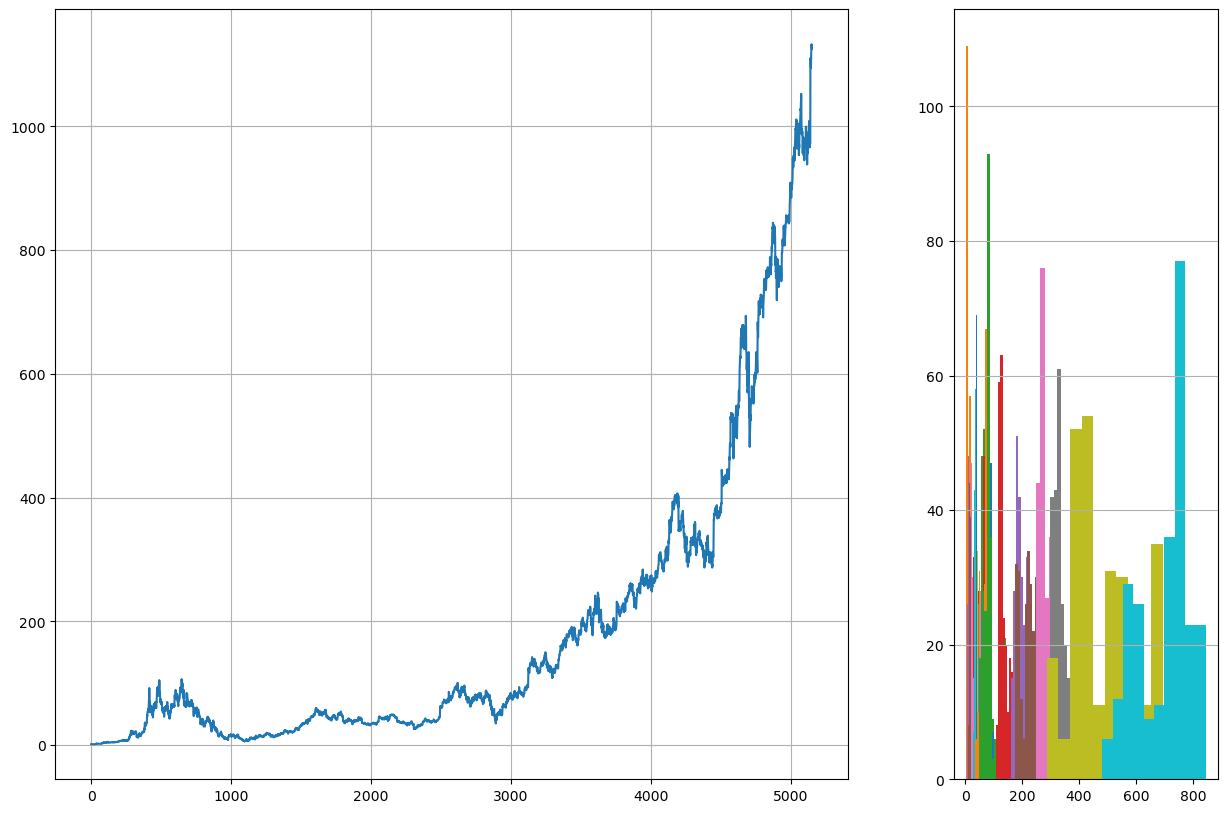

In [8]:
# Obtains the distribution of the data in each year
date_data = data["Date"].values.tolist()

date_slices = []
values = []
hists = []
x = 0
year = date_data[0].split("-")[0]

for i in range(0, len(date_data)):
    current_year = date_data[i].split("-")[0]
    values.append(data["Close_next"][i])

    if (current_year != year):
        date_slices.append([x,i,year, i-x])
        hists.append(values)
        year = current_year
        x = i
        values = []

# Obtains all the close prices
close_data = data["Close_next"].values.tolist()

dist = []

for i in range(0, len(date_slices)):
    dist.append(close_data[date_slices[i][0]:date_slices[i][1]])

# Plot the evolution of the prices and distribution
plot_data(close_data, dist)

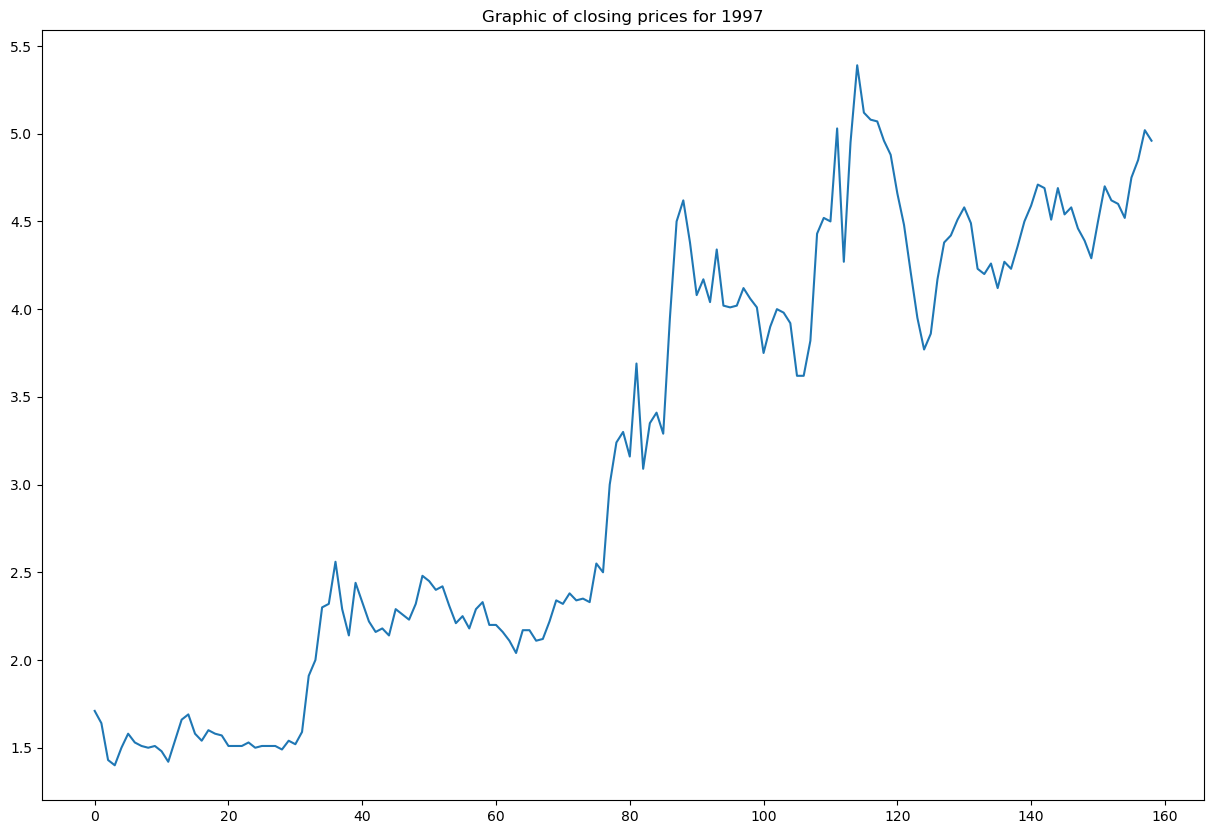

In [9]:
plt.title("Graphic of closing prices for 1997")
plt.plot(close_data[date_slices[0][0]:date_slices[0][1]])
plt.show()

What we want to show with this graph where we display the 1997 values is that in the first graph with the complete information it cant be appreciated correctly how the values changed in a year period of time.

### Imbalanced Analysis

In [10]:
print("Slices of records by year", date_slices)

Slices of records by year
[
    [0, 159, '1997', 159],
    [159, 411, '1998', 252],
    [411, 661, '1999', 250],
    [661, 913, '2000', 252],
    [913, 1161, '2001', 248],
    [1161, 1410, '2002', 249],
    [1410, 1662, '2003', 252],
    [1662, 1914, '2004', 252],
    [1914, 2166, '2005', 252],
    [2166, 2417, '2006', 251],
    [2417, 2668, '2007', 251],
    [2668, 2921, '2008', 253],
    [2921, 3173, '2009', 252],
    [3173, 3425, '2010', 252],
    [3425, 3677, '2011', 252],
    [3677, 3927, '2012', 250],
    [3927, 4179, '2013', 252],
    [4179, 4431, '2014', 252],
    [4431, 4683, '2015', 252],
    [4683, 4935, '2016', 252]
]

In [11]:
print("First date value", date_data[0])

First date value 1997-05-16

As seen in the previous two cells, distribution of the information is balanced between the years. Only 1997 has less amount of values and this is because the information available starts from may.

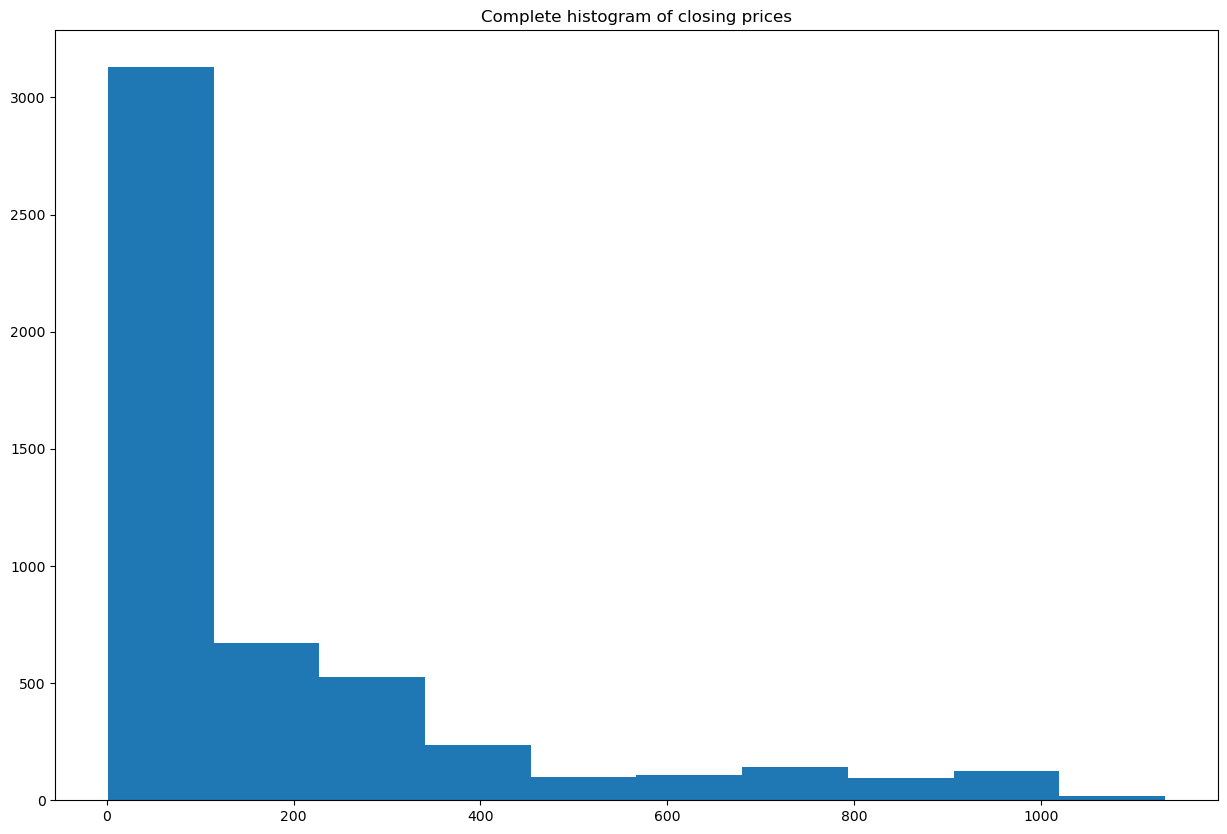

In [12]:
plt.title("Complete histogram of closing prices")
plt.hist(close_data)
plt.show()

(array([20.,  7., 29., 43., 58., 45., 21.,  9., 16.,  3.]),
 array([26.07, 28.25, 30.43, 32.61, 34.79, 36.97, 39.15, 41.33, 43.51,
        45.69, 47.87]),
 <BarContainer object of 10 artists>)

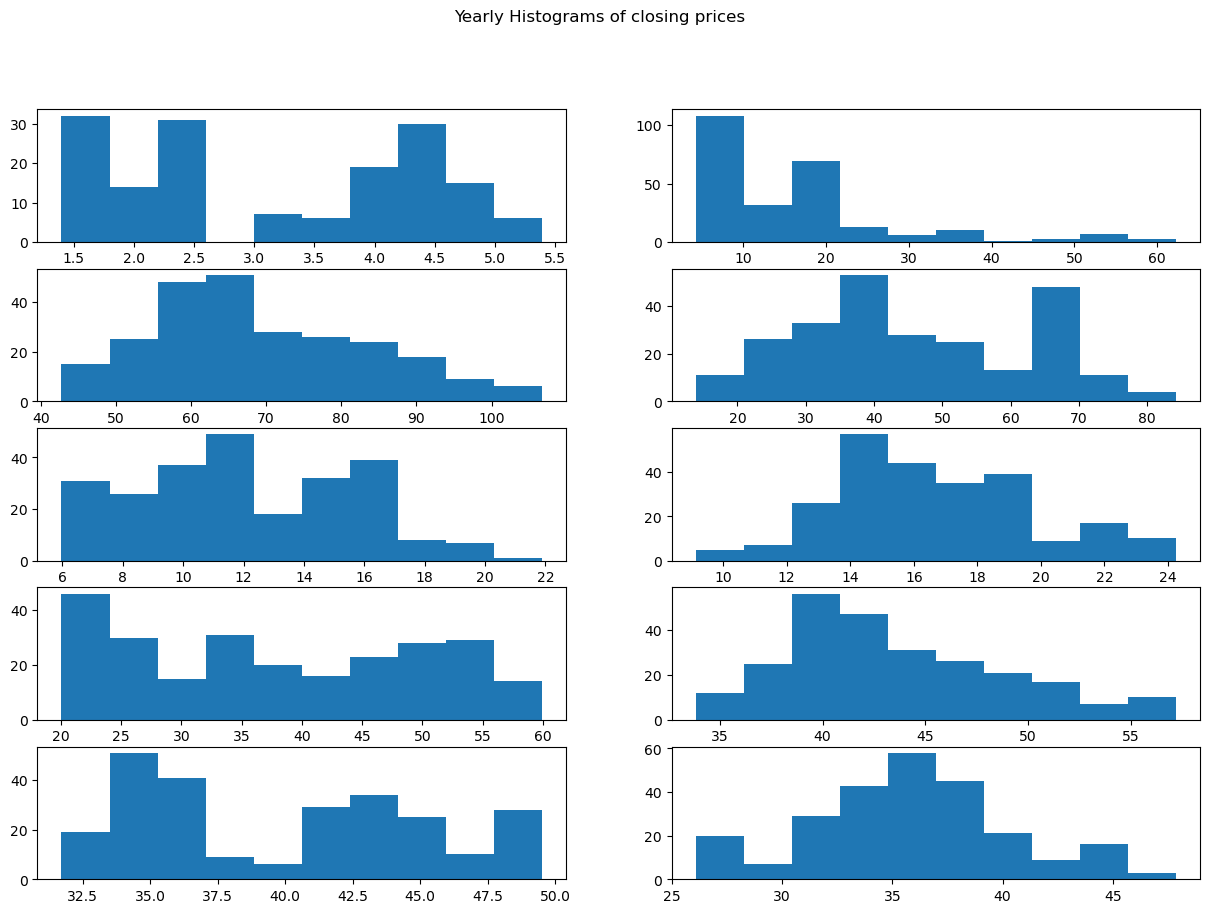

In [13]:
fig, axs = plt.subplots(5,2)
fig.suptitle('Yearly Histograms of closing prices')
axs[0,0].hist(hists[0])
axs[0,1].hist(hists[1])
axs[1,0].hist(hists[2])
axs[1,1].hist(hists[3])
axs[2,0].hist(hists[4])
axs[2,1].hist(hists[5])
axs[3,0].hist(hists[6])
axs[3,1].hist(hists[7])
axs[4,0].hist(hists[8])
axs[4,1].hist(hists[9])

In the previous two cells, histograms for the whole dataset and by year are visualized. This is to show that the distribution could seem imbalanced if we take the dataset as a whole set of a generic regression problem to resolve, but as it is actually a financial price progression, we distributed yearly to validate that the range of the data is ok.

### Zero, null, missing, duplicated values and outliers analysis

In [14]:
# Get the counts of all the null values
null_values = data.isnull().sum()
# Get the counts of all the missing values
missing_values = data.isnull().sum()
# Get the counts of all the missing values
zero_values = data.eq(0).sum()
# Get the counts of all the duplicated values
duplicates = data.duplicated().sum()

print("Null values:")
print(null_values)
print("Missing values:")
print(missing_values)
print("Zero values:")
print(zero_values)
print("Duplicates:")
print(duplicates)

Null values:

Date          0
Open          0
High          0
Low           0
Close         0
Volume        0
OpenInt       0
Close_next    0
dtype: int64

Missing values:

Date          0
Open          0
High          0
Low           0
Close         0
Volume        0
OpenInt       0
Close_next    0
dtype: int64

Zero values:

Date             0
Open             0
High             0
Low              0
Close            0
Volume           1
OpenInt       5152
Close_next       0
dtype: int64

Duplicates:

0

{'whiskers': [<matplotlib.lines.Line2D at 0x29a67bfe9b0>,
 'caps': [<matplotlib.lines.Line2D at 0x29a67bfeef0>,
 'boxes': [<matplotlib.lines.Line2D at 0x29a67bfe710>],
 'medians': [<matplotlib.lines.Line2D at 0x29a67bff430>],
 'fliers': [<matplotlib.lines.Line2D at 0x29a67bff6d0>],
 'means': []}

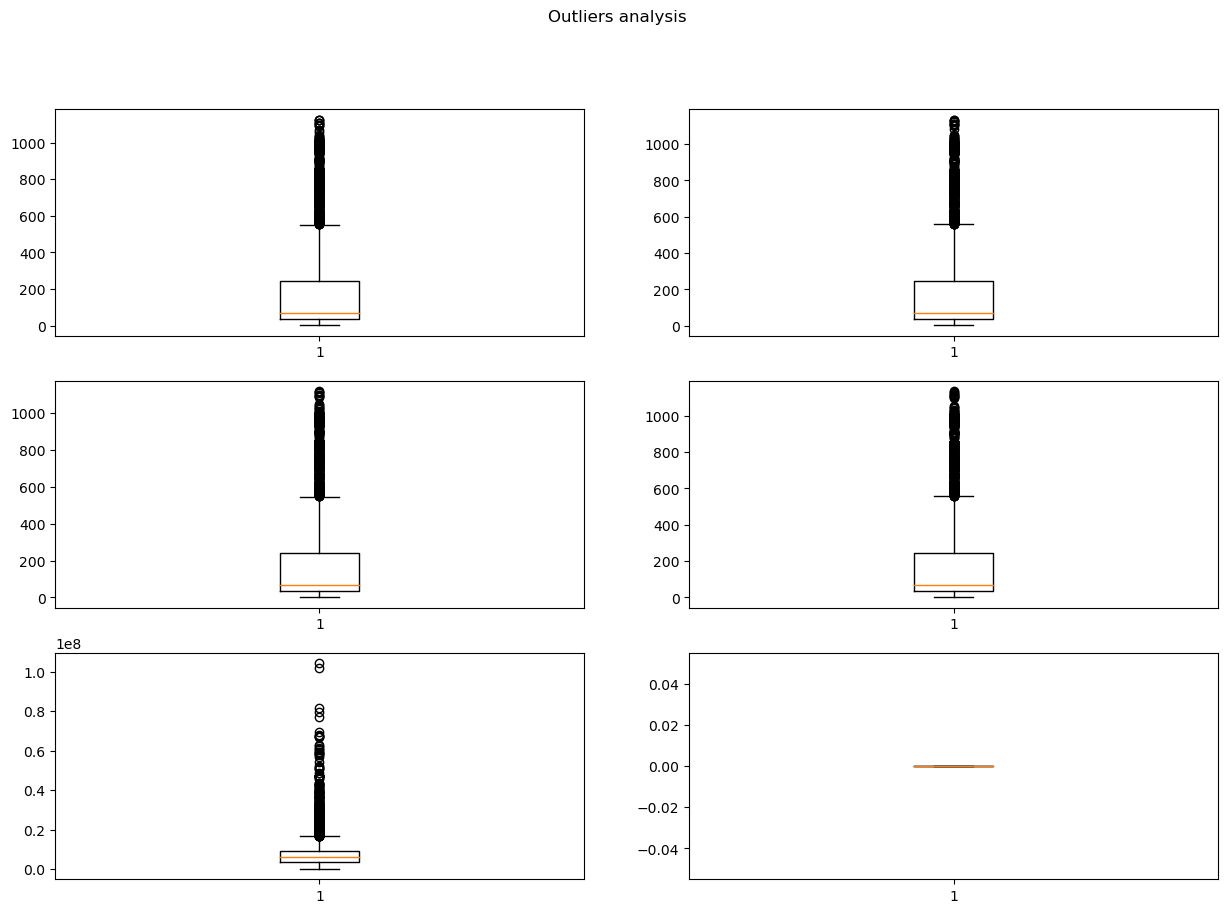

In [15]:
fig, axs = plt.subplots(3,2)
fig.suptitle('Outliers analysis')
axs[0,0].boxplot(data["Open"])
axs[0,1].boxplot(data["High"])
axs[1,0].boxplot(data["Low"])
axs[1,1].boxplot(data["Close"])
axs[2,0].boxplot(data["Volume"])
axs[2,1].boxplot(data["OpenInt"])

In the previous two cells an analysis of empty, null, zero, duplicated and outliers values have been realize.
No empty, null or duplicated values where detected in the dataset. 
Zero values where detected for OpenInt (column will not be used in the model) and in Volume, where only one row has a zero.
As for outliers, possible values where detected in Volume.

As this is a financial analysis problem, the zero and possible outliers in the column volume will not be modified as they are actual values needed to be part of the dataset, so they must be included in the training of the model.

### Metrics analysis

In [16]:
# Train a Linear Regression using scaler to see the possible metrics.
test_metrics = [metrics.RMSE(), metrics.MSE(), metrics.MAE(), metrics.R2()]

for i in range(0,len(test_metrics)):
    # Prepare the pipeline with the preprocessing steps and the model to be used
    model = compose.Pipeline(
        preprocessing.StandardScaler(), # Prepare the data centered in avg 0 and std 1
        linear_model.LinearRegression()
    )

    for sample, target in getAmazonStockDataSet(dataset_path):
        target_prediction = model.predict_one(sample)
        
        model.learn_one(sample, float(target))
        test_metrics[i].update(target, target_prediction)
        
    print(sample, target, target_prediction, test_metrics[i])

{'Open': 1125.96, 'High': 1129.62, 'Low': 1115.77, 'Close': 1129.13, 'Volume': 3729978}
1125.35 1120.6614809443784 RMSE: 7.519947

{'Open': 1125.96, 'High': 1129.62, 'Low': 1115.77, 'Close': 1129.13, 'Volume': 3729978}
1125.35 1120.6614809443784 MSE: 56.549598

{'Open': 1125.96, 'High': 1129.62, 'Low': 1115.77, 'Close': 1129.13, 'Volume': 3729978}
1125.35 1120.6614809443784 MAE: 4.159005

{'Open': 1125.96, 'High': 1129.62, 'Low': 1115.77, 'Close': 1129.13, 'Volume': 3729978}
1125.35 1120.6614809443784 R2: 0.999014

Just a little analysis to see what are the general metrics values. As stated in the description of the problem, MSE will be use.

## Data drifts

Selection of the concept drift detector:

Drift Detection Method, Early Drift Detection Method, Drift Detection Method based on Hoeffding's where not take in account for this analysis because they are not good for regression problems as they expect as an entry a stream of bits, where 1 indicates error/failure and 0 represents correct/normal values. A conversion could be made to take ranges but it was not considered necessary as the other detectors are sufficient.

Periodic trigger was discarded as it just generate the drift in a configurable periodic time, not actually analyzing the values. 

That leaves us with the three possible methods to use: </br>
ADWIN: based on a variable-length window of recent items.
https://riverml.xyz/0.14.0/api/drift/ADWIN/ </br>

KSWIN: based on Kolmogorov-Smirnov (KS) statistical test.
https://riverml.xyz/0.14.0/api/drift/KSWIN/ </br>

Page Hinkley: based on the mean of the values.
https://riverml.xyz/0.14.0/api/drift/PageHinkley/ </br>

The data drift detector of this three methods for target, features and a basic model was implemented in the next cells both for the target as for the features.

### ADWIN

Number of drifts detected: 65

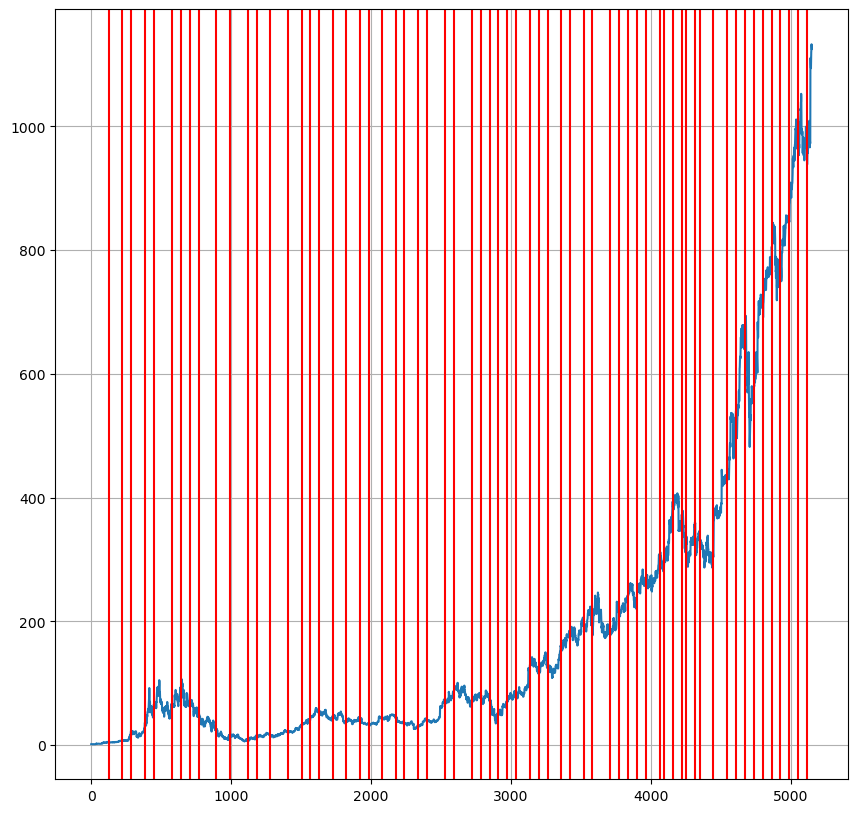

In [17]:
# Get data drift for target
drift_detector = drift.ADWIN()
target_drifts = []

for i, val in enumerate(close_data):
    drift_detector.update(val)   # Data is processed one sample at a time
    if drift_detector.drift_detected:
        # The drift detector indicates after each sample if there is a drift in the data
        target_drifts.append(i)

print ("Number of drifts detected:", len(target_drifts))
# Plot the data with concept drift analysis
plot_drift(close_data, target_drifts)

Number of drifts detected in: Open 67

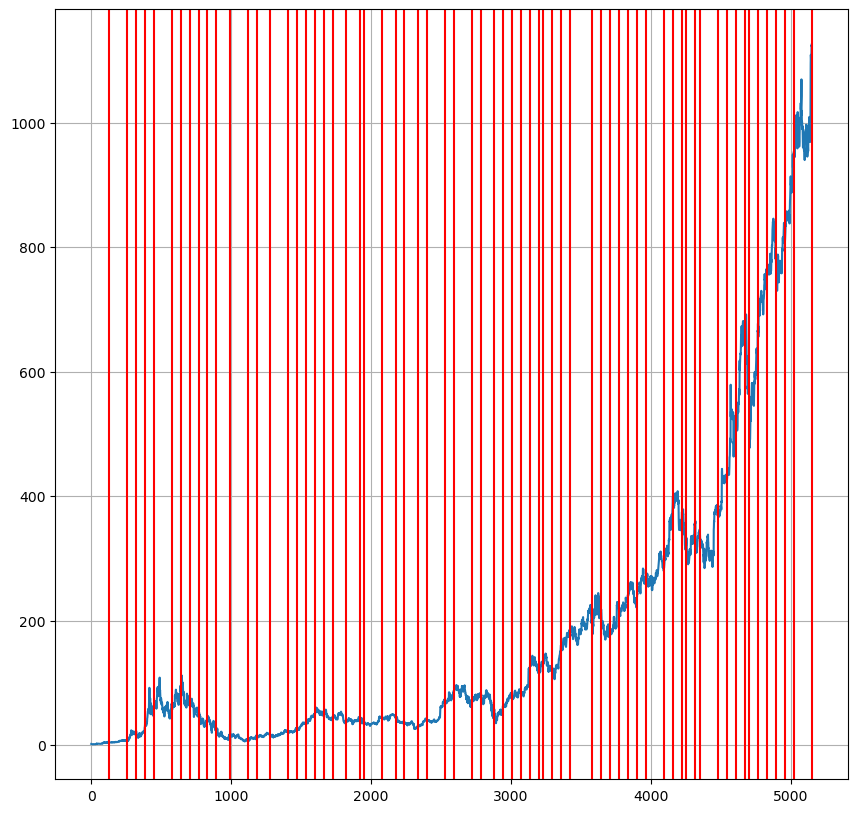

Number of drifts detected in: High 67

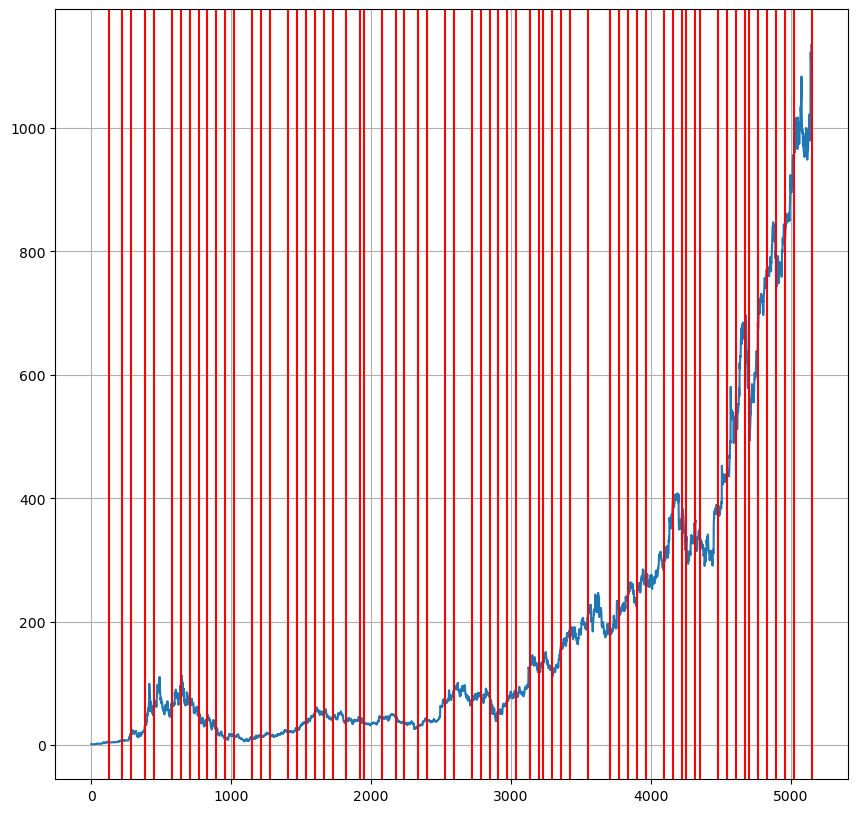

Number of drifts detected in: Low 65

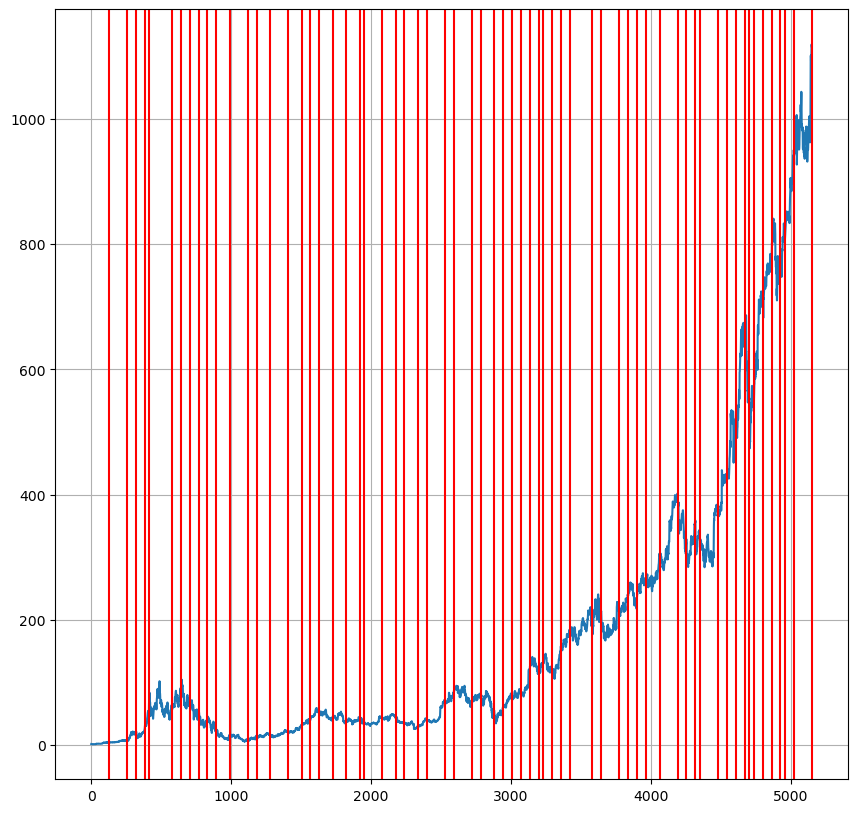

Number of drifts detected in: Close 63

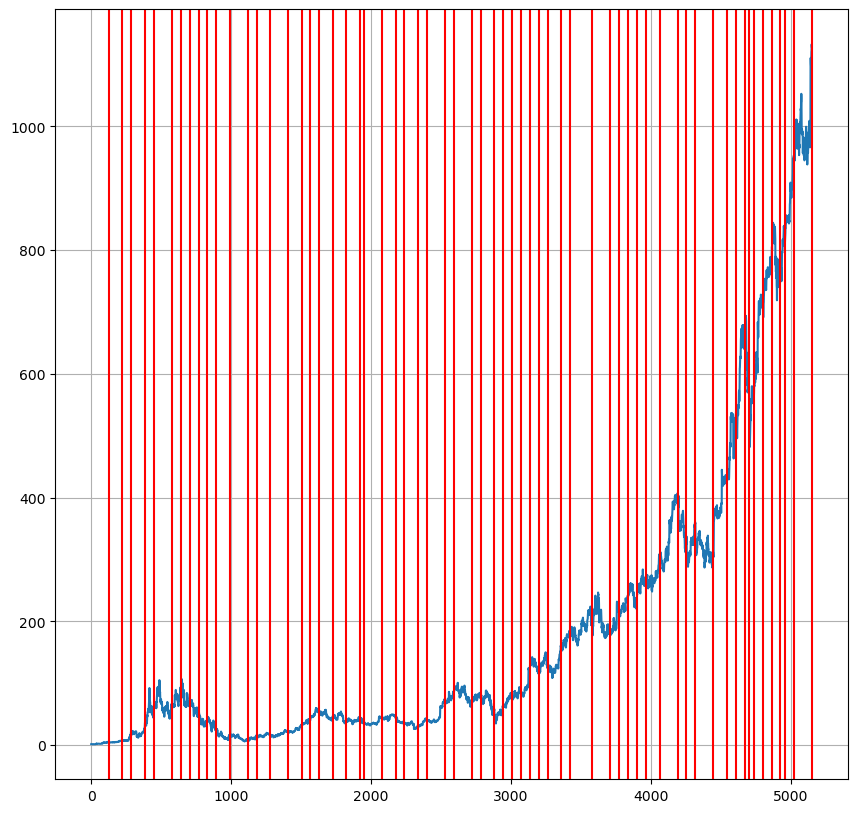

Number of drifts detected in: Volume 14

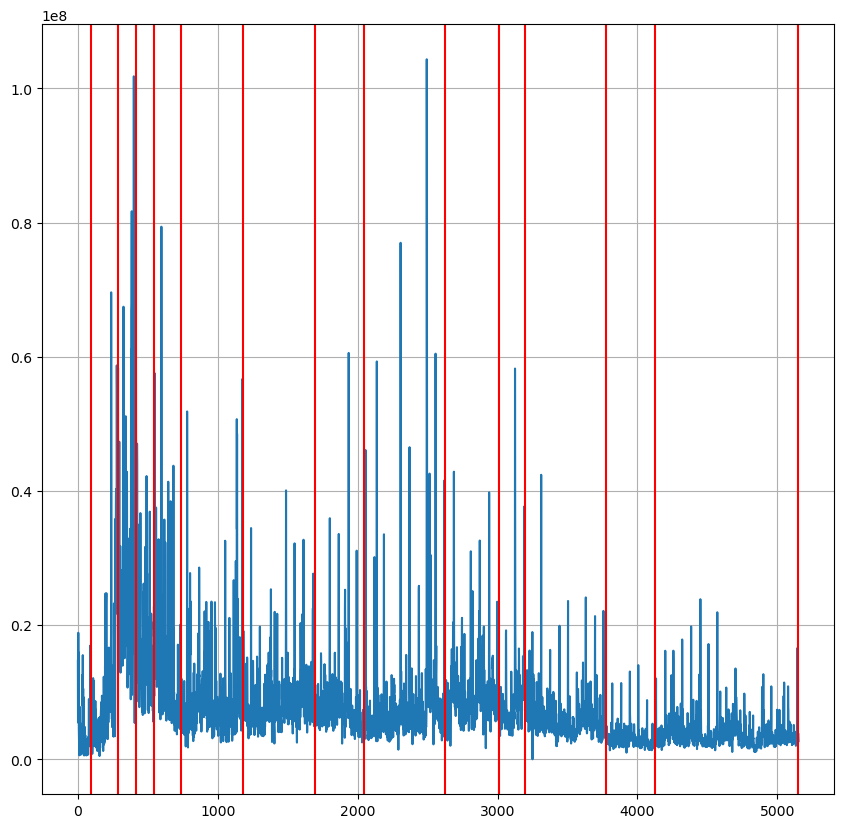

In [18]:
# Get data drift for features
features = ["Open","High","Low","Close","Volume"]

for i in range(0, len(features)):
    drf_data = data[features[i]].values.tolist()

    drift_detector = drift.ADWIN()
    feature_drifts = []

    for x, val in enumerate(drf_data):
        drift_detector.update(val)   # Data is processed one sample at a time
        if drift_detector.drift_detected:
            # The drift detector indicates after each sample if there is a drift in the data
            feature_drifts.append(x)

    print ("Number of drifts detected in:", features[i] , len(feature_drifts))
    # Plot the data with concept drift analysis on the target
    plot_drift(drf_data, feature_drifts)

{'Open': 1125.96, 'High': 1129.62, 'Low': 1115.77, 'Close': 1129.13, 'Volume': 3729978}
1125.35 1120.6614809443784

MSE: 56.549598

38

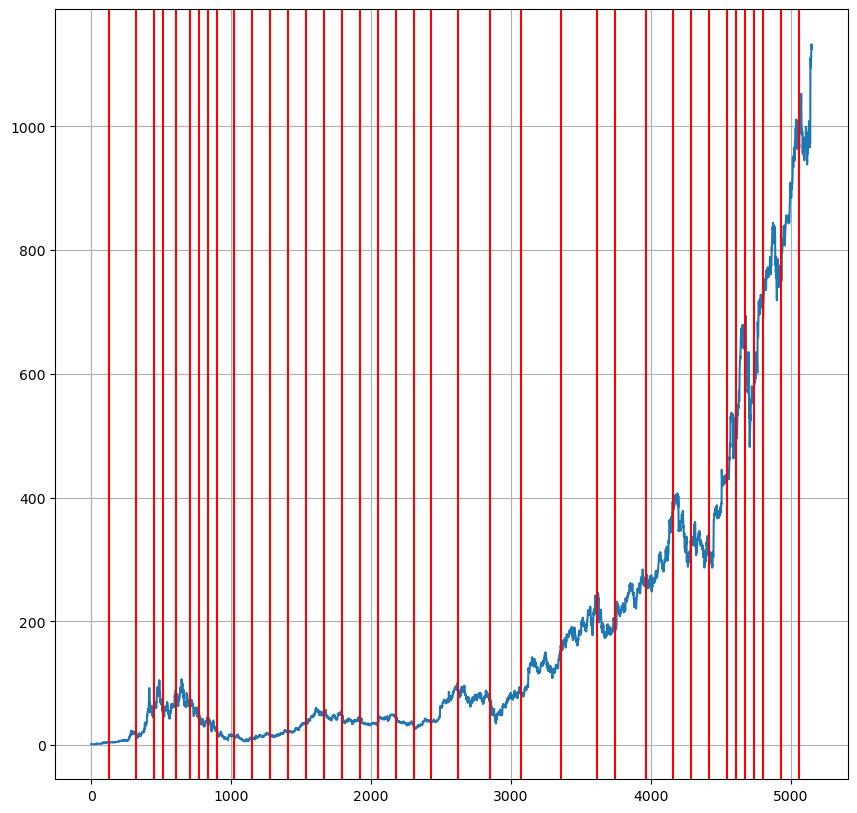

In [19]:
# Get data drift for basic model with MSE metrics
drift_detector = drift.ADWIN()
drifts_detected = []

# Train a Linear Regression using scaler

# Prepare the pipeline with the preprocessing steps and the model to be used
model = compose.Pipeline(
    preprocessing.StandardScaler(), # Prepare the data centered in avg 0 and std 1
    linear_model.LinearRegression()
)
metric = metrics.MSE()

count = 0
for sample, target in getAmazonStockDataSet(dataset_path):
    target_prediction = model.predict_one(sample)
    
    model.learn_one(sample, float(target))
    metric.update(target, target_prediction)
    
    count = count + 1

    drift_detector.update(metric.get())

    if drift_detector.drift_detected:
        drifts_detected.append(count)
        #print(f'Change detected at index {count} Metric of the model {metric}. Metric of the drift {drift_detector.estimation}')

print(sample, target, target_prediction)
print(metric)
print(len(drifts_detected))

# Plot the data with concept drift analysis on the target
plot_drift(close_data, drifts_detected)

### KSWIN

Number of drifts detected in target 49

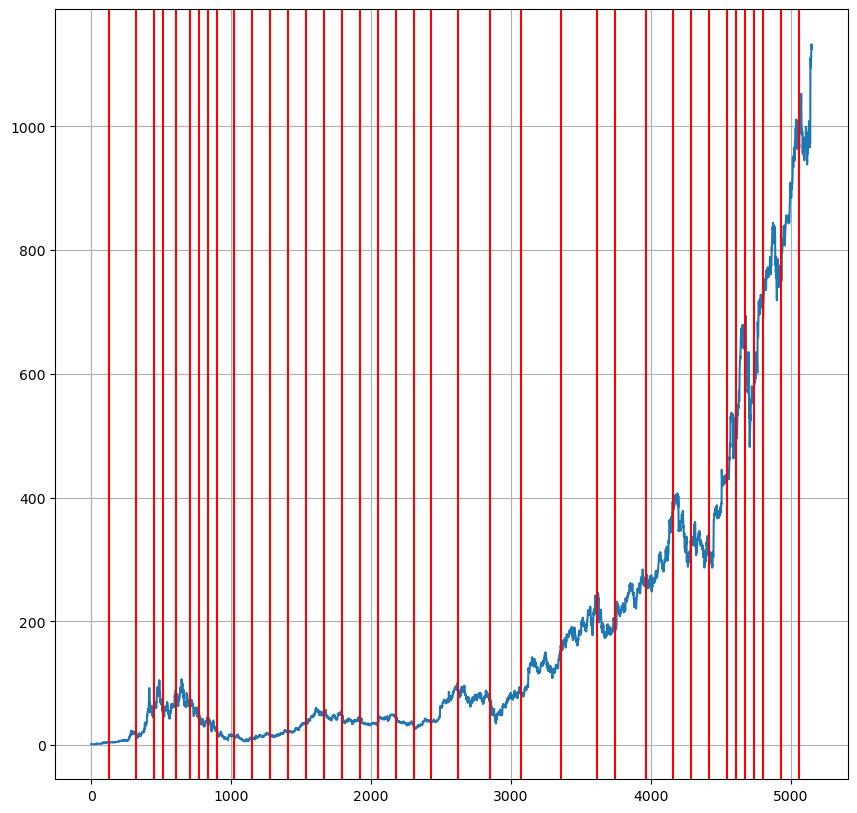

In [20]:
# Drift with target
drift_detector = drift.KSWIN(alpha=0.0001, seed=42)
target_drifts = []

for i, val in enumerate(close_data):
    drift_detector.update(val)   # Data is processed one sample at a time
    if drift_detector.drift_detected:
        # The drift detector indicates after each sample if there is a drift in the data
        #print(f'Change detected at index {i}')
        target_drifts.append(i)

print ("Number of drifts detected in target" , len(target_drifts))
# Plot the data with concept drift analysis
plot_drift(close_data, drifts_detected)

Number of drifts detected in: Open 49

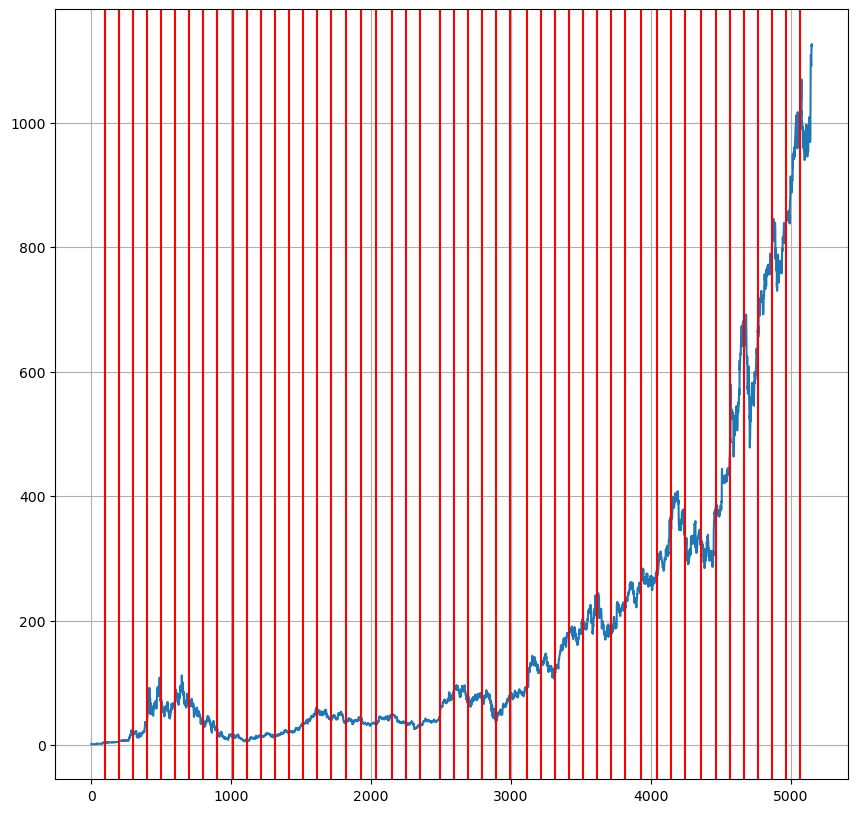

Number of drifts detected in: High 49

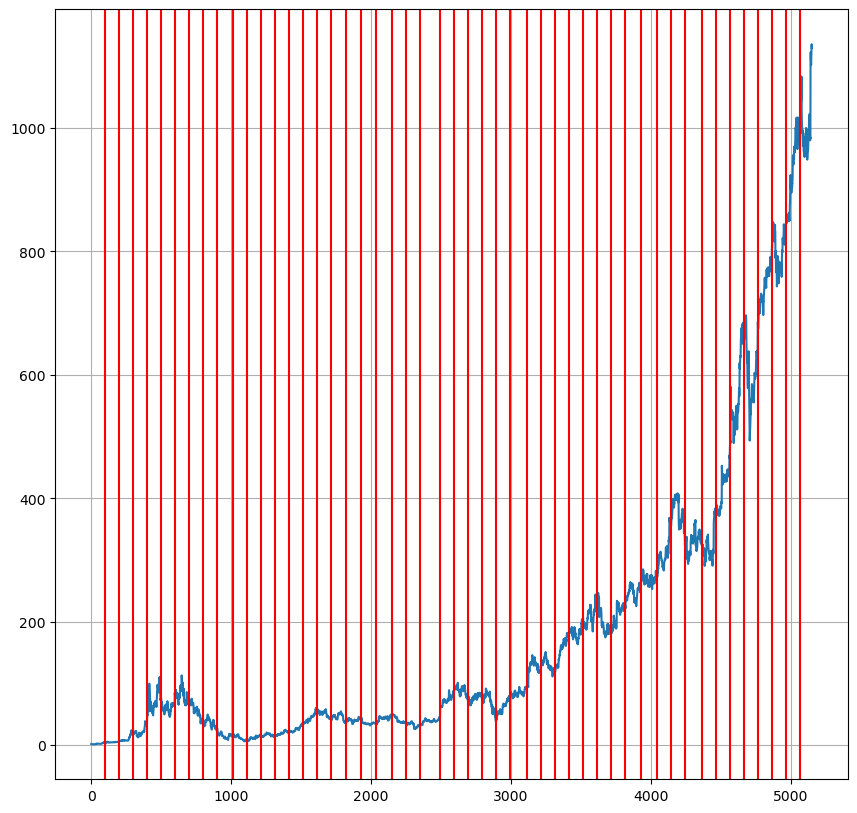

Number of drifts detected in: Low 49

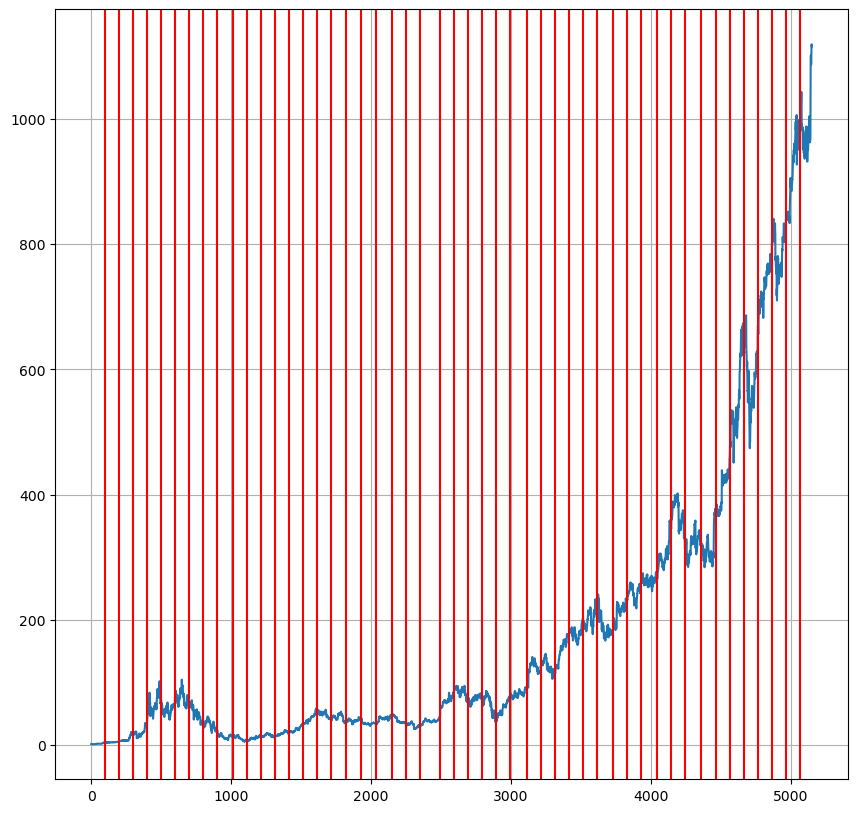

Number of drifts detected in: Close 49

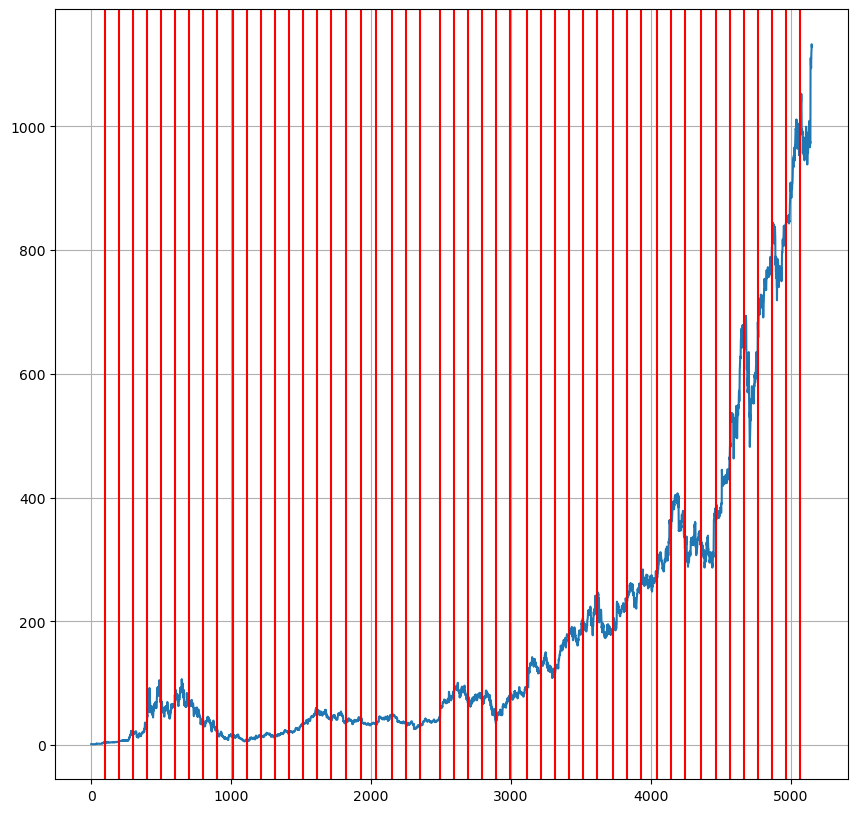

Number of drifts detected in: Volume 30

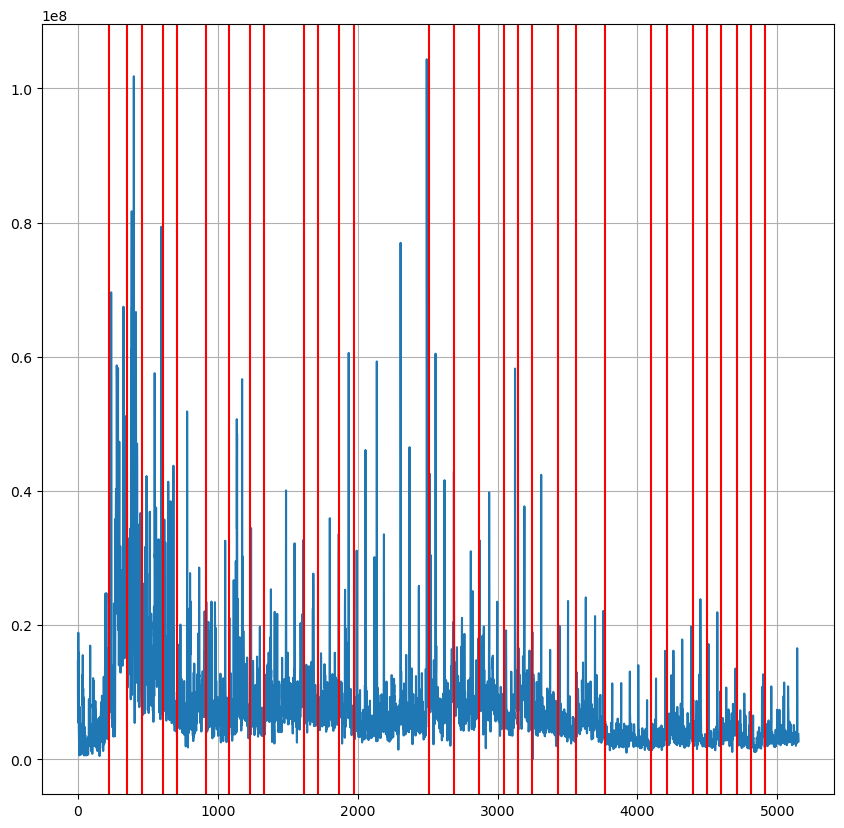

In [21]:
for i in range(0, len(features)):
    drf_data = data[features[i]].values.tolist()

    drift_detector = drift.KSWIN(alpha=0.0001, seed=42)
    feature_drifts = []

    for x, val in enumerate(drf_data):
        drift_detector.update(val)   # Data is processed one sample at a time
        if drift_detector.drift_detected:
            # The drift detector indicates after each sample if there is a drift in the data
            feature_drifts.append(x)

    print ("Number of drifts detected in:", features[i] , len(feature_drifts))
    # Plot the data with concept drift analysis on the target
    plot_drift(drf_data, feature_drifts)

{'Open': 1125.96, 'High': 1129.62, 'Low': 1115.77, 'Close': 1129.13, 'Volume': 3729978}
1125.35 1120.6614809443784

MSE: 56.549598

51

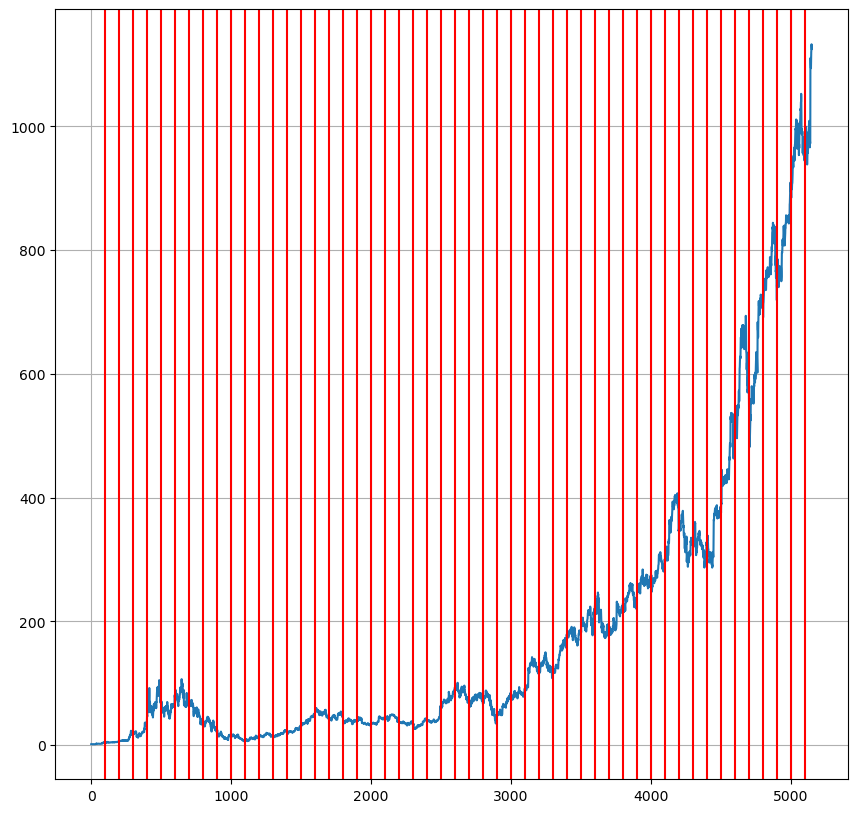

In [22]:
# Get datadrift for basic model with MSE metrics
drift_detector = drift.KSWIN()
drifts_detected = []

# Train a Linear Regression using scaler

# Prepare the pipeline with the preprocessing steps and the model to be used
model = compose.Pipeline(
    preprocessing.StandardScaler(), # Prepare the data centered in avg 0 and std 1
    linear_model.LinearRegression()
)
metric = metrics.MSE()

count = 0
for sample, target in getAmazonStockDataSet(dataset_path):
    target_prediction = model.predict_one(sample)
    
    model.learn_one(sample, float(target))
    metric.update(target, target_prediction)
    
    count = count + 1

    drift_detector.update(metric.get())

    if drift_detector.drift_detected:
        drifts_detected.append(count)
        #print(f'Change detected at index {count} Metric of the model {metric}. Metric of the drift {drift_detector.estimation}')

print(sample, target, target_prediction)
print(metric)
print(len(drifts_detected))

# Plot the data with concept drift analysis on the target
plot_drift(close_data, drifts_detected)

### Page Hinkley

Number of drifts detected: 144

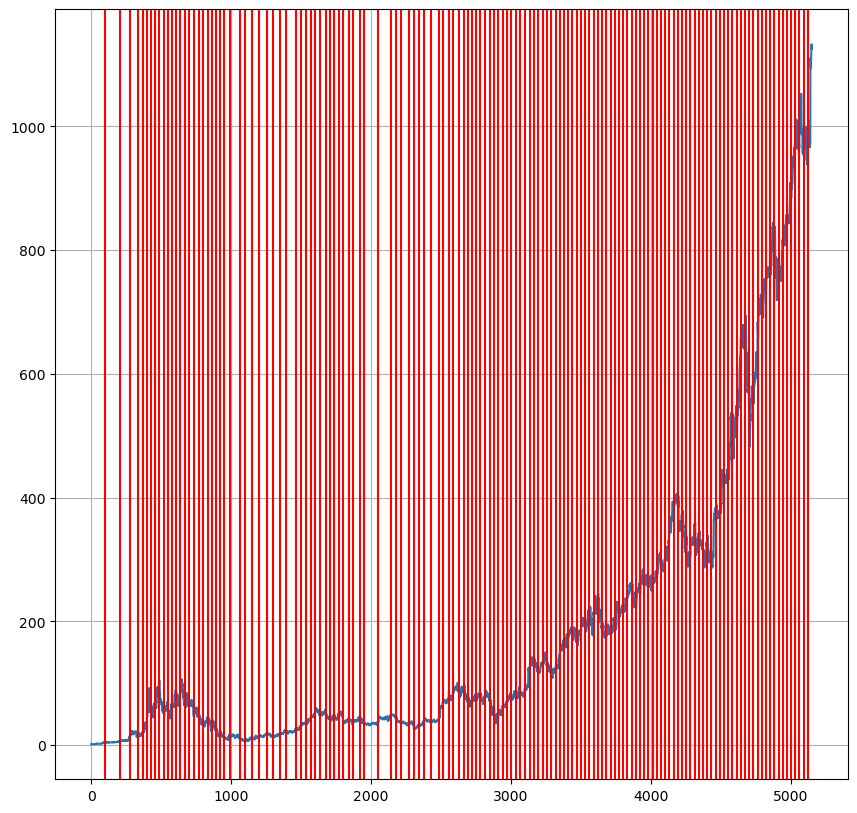

In [23]:
# Get drift for target
drift_detector = drift.PageHinkley()
target_drifts = []

for i, val in enumerate(close_data):
    drift_detector.update(val)   # Data is processed one sample at a time
    if drift_detector.drift_detected:
        # The drift detector indicates after each sample if there is a drift in the data
        #print(f'Change detected at index {i}')
        target_drifts.append(i)

print ("Number of drifts detected:", len(target_drifts))
# Plot the data with concept drift analysis
plot_drift(close_data, target_drifts)

Number of drifts detected in: Open 144

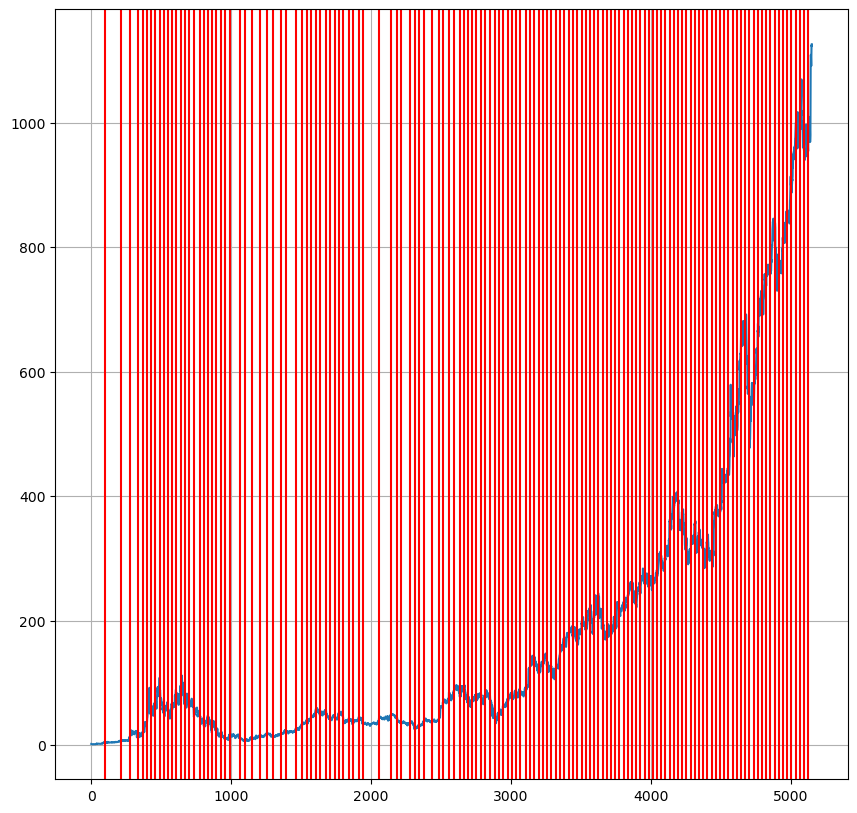

Number of drifts detected in: High 144

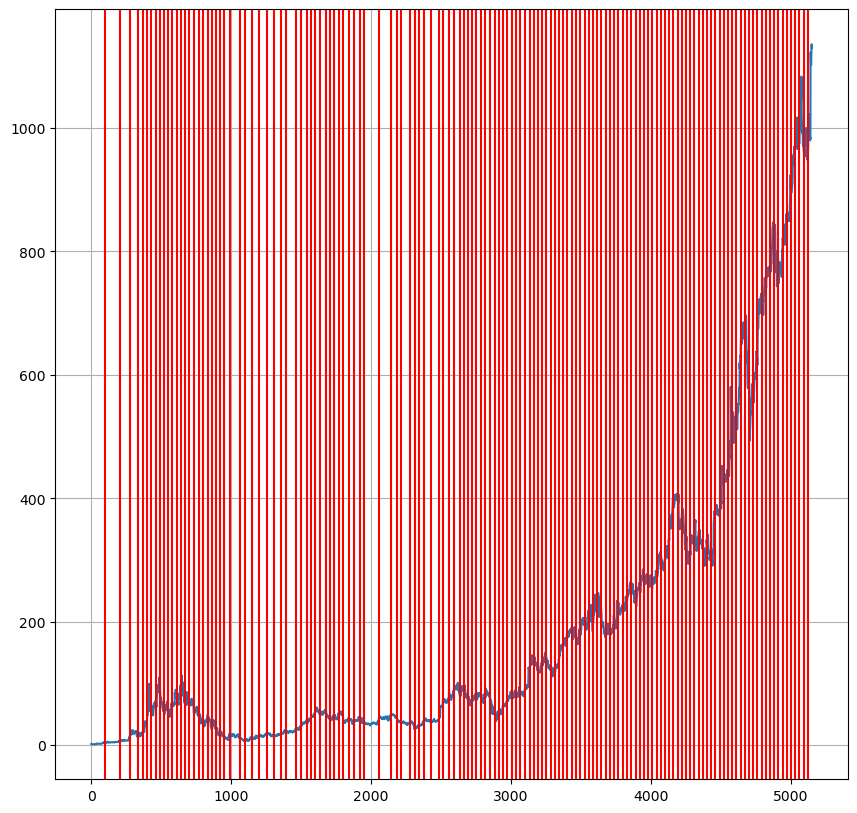

Number of drifts detected in: Low 145

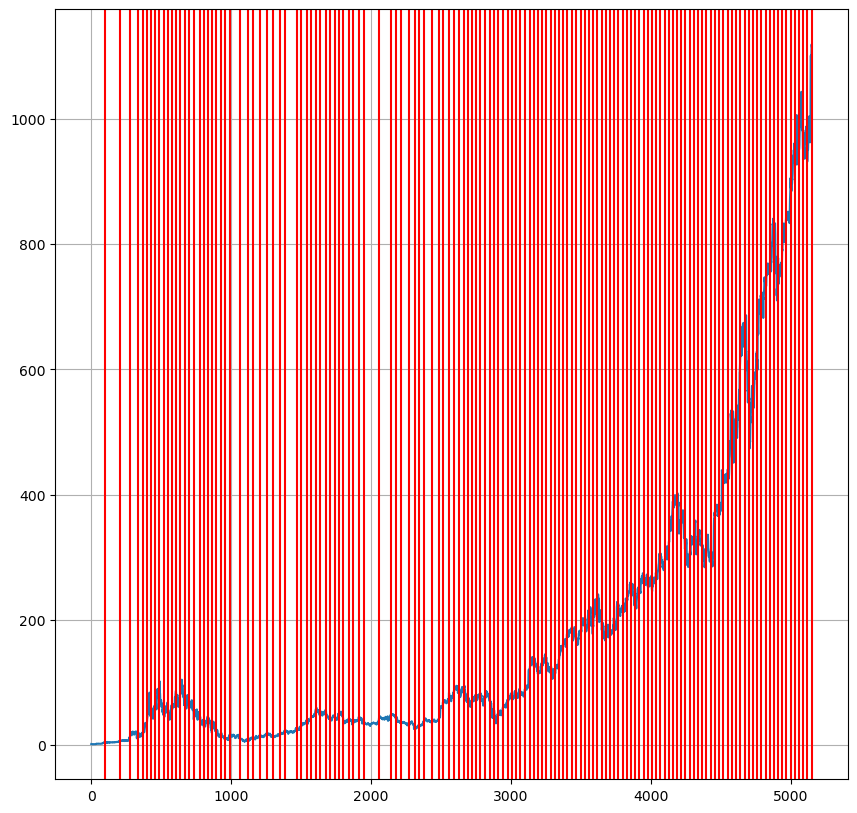

Number of drifts detected in: Close 144

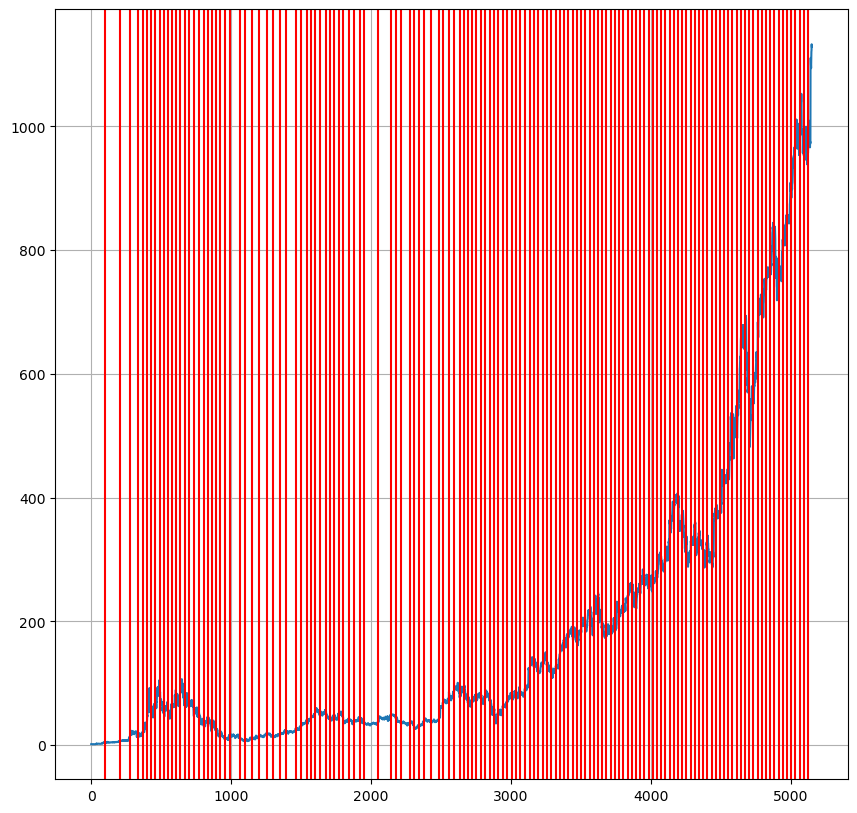

Number of drifts detected in: Volume 171

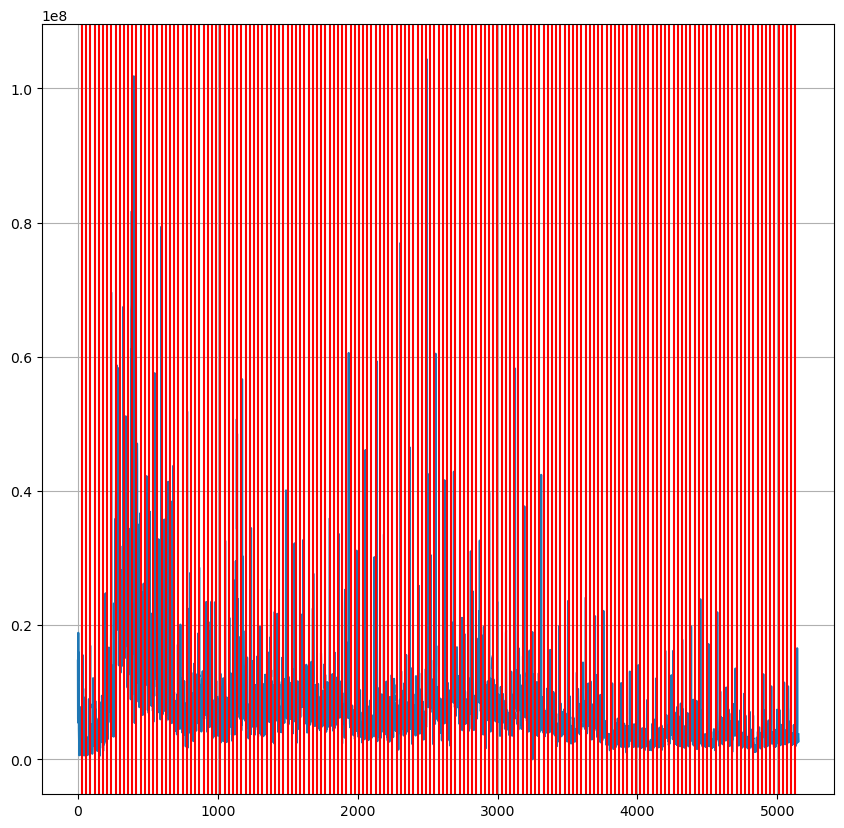

In [24]:
# Get drift for features
for i in range(0, len(features)):
    drf_data = data[features[i]].values.tolist()

    drift_detector = drift.PageHinkley()
    feature_drifts = []

    for x, val in enumerate(drf_data):
        drift_detector.update(val)   # Data is processed one sample at a time
        if drift_detector.drift_detected:
            # The drift detector indicates after each sample if there is a drift in the data
            feature_drifts.append(x)

    print ("Number of drifts detected in:", features[i] , len(feature_drifts))
    # Plot the data with concept drift analysis on the target
    plot_drift(drf_data, feature_drifts)

{'Open': 1125.96, 'High': 1129.62, 'Low': 1115.77, 'Close': 1129.13, 'Volume': 3729978}
1125.35 1120.6614809443784

MSE: 56.549598

39

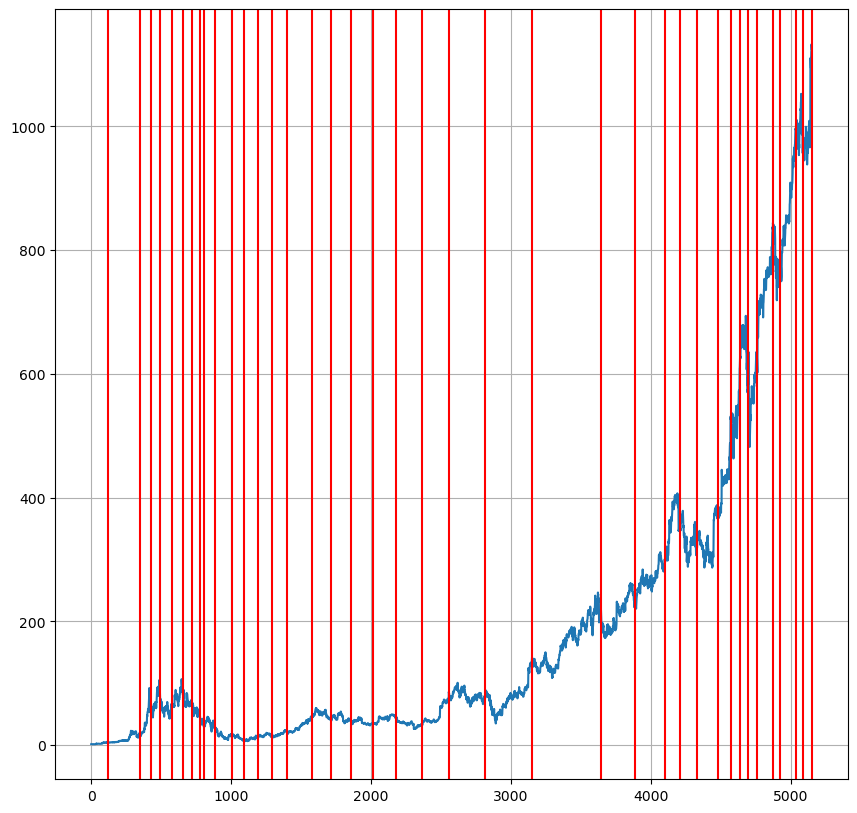

In [25]:
# Get datadrift for basic model with MSE metrics
drift_detector = drift.PageHinkley()
drifts_detected = []

# Train a Linear Regression using scaler

# Prepare the pipeline with the preprocessing steps and the model to be used
model = compose.Pipeline(
    preprocessing.StandardScaler(), # Prepare the data centered in avg 0 and std 1
    linear_model.LinearRegression()
)
metric = metrics.MSE()

count = 0
for sample, target in getAmazonStockDataSet(dataset_path):
    target_prediction = model.predict_one(sample)
    
    model.learn_one(sample, float(target))
    metric.update(target, target_prediction)
    
    count = count + 1

    drift_detector.update(metric.get())

    if drift_detector.drift_detected:
        drifts_detected.append(count)
        #print(f'Change detected at index {count} Metric of the model {metric}. Metric of the drift {drift_detector.estimation}')

print(sample, target, target_prediction)
print(metric)
print(len(drifts_detected))

# Plot the data with concept drift analysis on the target
plot_drift(close_data, drifts_detected)

## Batch Learning

First we split the dataset in training and test. No need to take special consideration such as Stratified and Grouped technics as is a regression situation for a financial problem with a very balanced dataset.  

In [26]:
# Read the dataset and split
data = pd.read_csv(dataset_path)

df_train, df_test = train_test_split(data, 
                                    train_size = 0.8, 
                                    test_size = 0.2, 
                                    random_state = 10)

x_train = df_train[['Open', 'High', 'Low', 'Close', 'Volume']]
y_train = df_train['Close_next']
x_test = df_test[['Open', 'High', 'Low', 'Close', 'Volume']]
y_test = df_test['Close_next']

### Test use of standarization

In [27]:
# We define a Pipeline, because we need a single object 
model = Pipeline(
    # From river documentation:
    # It is generally a good idea to scale the data beforehand in order for the optimizer to converge. 
    # You can do this online with a preprocessing.StandardScaler.
    ('ml_model', linear_model.LinearRegression())
)

# This function returns an object of type SKLRegressorWrapper 
# which is compatible with the signature of sklearn
model = convert_river_to_sklearn(model)

scorer = make_scorer(mean_squared_error)

# Shuffle false so have the same dataset that the online learning model
folds = KFold(n_splits = 5, shuffle = False)

scores = cross_val_score(model, x_train, y_train, scoring=scorer, cv=folds)

print(scores)
print(scores.mean())

[8.89889124e+46 7.79354333e+46 8.35982281e+46 1.07259712e+47
 8.21132249e+46]

8.797910206638739e+46

In [28]:
# We define a Pipeline, because we need a single object 
model = Pipeline(
    ('scale', preprocessing.StandardScaler()),
    ('ml_model', linear_model.LinearRegression())
)

# This function returns an object of type SKLRegressorWrapper 
# which is compatible with the signature of sklearn
model = convert_river_to_sklearn(model)

scorer = make_scorer(mean_squared_error)

# Shuffle false so have the same dataset that the online learning model
folds = KFold(n_splits = 5, shuffle = False)

scores = cross_val_score(model, x_train, y_train, scoring=scorer, cv=folds)

print(scores)
print(scores.mean())

[37.53565961 33.6377768  32.96420556 30.48373996 54.50682145]

37.825640676194936

As it can be seen in the previous two cells, as it was stated in the data selection section, the use of standarization gives the model a much more better prediction.

### Test use of optimizer

In [29]:
# Train a Linear Regression using scaler
model = Pipeline(
    ('scale', preprocessing.StandardScaler()),
    ('ml_model', linear_model.LinearRegression())
)
    
# This function returns an object of type SKLRegressorWrapper 
# which is compatible with the signature of sklearn
model = convert_river_to_sklearn(model)

scorer = make_scorer(mean_squared_error)

# Shuffle false so have the same dataset that the online learning model
folds = KFold(n_splits = 5, shuffle = False)

scores = cross_val_score(model, x_train, y_train, scoring=scorer, cv=folds)

print(scores, scores.mean())

[37.53565961 33.6377768  32.96420556 30.48373996 54.50682145] 37.825640676194936

In [30]:
# Train a Linear Regression using scaler. Add optimizer for testing, no difference detected.
optimizer = SGD(lr=0.01)

# Train a Linear Regression using scaler
model = Pipeline(
       ('scale', preprocessing.StandardScaler()),
        ('ml_model', linear_model.LinearRegression(optimizer))
    )
    
# This function returns an object of type SKLRegressorWrapper 
# which is compatible with the signature of sklearn
model = convert_river_to_sklearn(model)

scorer = make_scorer(mean_squared_error)

# Shuffle false so have the same dataset that the online learning model
folds = KFold(n_splits = 5, shuffle = False)

scores = cross_val_score(model, x_train, y_train, scoring=scorer, cv=folds)

print(scores, scores.mean())

[37.53565961 33.6377768  32.96420556 30.48373996 54.50682145] 37.825640676194936

### Test different models

In [31]:
def train_batch(model, shuffle_kfold = False):
    model = Pipeline(
        ('scale', preprocessing.StandardScaler()),
        ('ml_model', model)
    )
    # This function returns an object of type SKLRegressorWrapper 
    # which is compatible with the signature of sklearn
    model = convert_river_to_sklearn(model)

    scorer = make_scorer(mean_squared_error)

    if shuffle_kfold:
        folds = KFold(n_splits = 5, shuffle = True, random_state=42)
    else:
        # Shuffle false so have the same dataset that the online learning model
        folds = KFold(n_splits = 5, shuffle = False)

    # Use the sklearn crossvalidation
    scores = cross_val_score(model, x_train, y_train, scoring=scorer, cv=folds)

    print(scores, scores.mean())

    return scores

In [32]:
final_metrics_batch = []
models_batch = []

In [33]:
# Train a Linear Regression using scaler
scores = train_batch(linear_model.LinearRegression())

final_metrics_batch.append(scores.mean())
models_batch.append("Linear")

[37.53565961 33.6377768  32.96420556 30.48373996 54.50682145] 37.825640676194936

In [34]:
# Train a Linear Regression using scaler and shuffle fold
scores = train_batch(linear_model.LinearRegression(), shuffle_kfold=True)

final_metrics_batch.append(scores.mean())
models_batch.append("Linear SH")

[38.2206438  33.50322921 32.26140237 33.16135818 47.13819594] 36.85696590151834

In [35]:
# Train a Linear Regression using scaler and regularization
scores = train_batch(linear_model.LinearRegression(l2=0.2))

final_metrics_batch.append(scores.mean())
models_batch.append("Linear Reg")

[101.63324358  92.2794853   91.8837186  102.59408564  55.65904079] 88.80991478009278

In [36]:
# Train a Bayesian regression
scores = train_batch(linear_model.BayesianLinearRegression)

final_metrics_batch.append(scores.mean())
models_batch.append("Bayes")

[35244.36629874 35197.75797105 35293.25780295 35733.90577457
 35502.26635472] 35394.31084040752

In [37]:
scores = train_batch(tree.HoeffdingTreeRegressor)

final_metrics_batch.append(scores.mean())
models_batch.append("HT200")

[37.53565961 33.6377768  32.96420556 30.48373996 54.50682145] 37.825640676194936

In [38]:
scores = train_batch(tree.HoeffdingTreeRegressor(grace_period=500))

final_metrics_batch.append(scores.mean())
models_batch.append("HT500")

[37.53565961 33.6377768  32.96420556 30.48373996 54.50682145] 37.825640676194936

In [39]:
scores = train_batch(tree.HoeffdingTreeRegressor(grace_period=100))

final_metrics_batch.append(scores.mean())
models_batch.append("HT100")

[37.53565961 33.6377768  32.96420556 30.48373996 54.50682145] 37.825640676194936

In [40]:
scores = train_batch(neighbors.KNNRegressor)

final_metrics_batch.append(scores.mean())
models_batch.append("KNN")

[69.96871736 88.60636293 72.76138894 96.74364879 99.32350526] 85.48072465331099

In [41]:
scores = train_batch(ensemble.AdaptiveRandomForestRegressor)

final_metrics_batch.append(scores.mean())
models_batch.append("RF")

[264.93527009 133.33153388 301.1705983  361.13003453 337.37830141] 279.58914764163785

In [42]:
scores = train_batch(ensemble.BaggingRegressor(linear_model.LinearRegression()))

final_metrics_batch.append(scores.mean())
models_batch.append("BagLR")

[38.75665431 33.1091501  32.39210964 29.94880718 46.79035157] 36.19941455920188

In [43]:
scores = train_batch(ensemble.BaggingRegressor(tree.HoeffdingTreeRegressor()))

final_metrics_batch.append(scores.mean())
models_batch.append("BagHT200")

[38.82327696 33.09629244 32.42067184 29.78226377 42.94849215] 35.414199432745924

The test set is splitted from the train set at the begging of the section but is not used to evaluate the model, we use the crossvalidation results on the train set (as the split in validation set is done inside that function). In the result section we obtain the real metrics of the best models using the test set.

## Stream Learning

### Test use of standarization

In [44]:
# Train a Linear Regression
model = linear_model.LinearRegression()
metric = metrics.MSE()

count = 0
for sample, target in getAmazonStockDataSet(dataset_path):
    target_prediction = model.predict_one(sample)
    
    model.learn_one(sample, float(target))
    metric.update(target, target_prediction)
    
    if (count % 1500==0):
        print(sample, target, target_prediction)
    count = count + 1

print(sample, target, target_prediction)
print(metric)

{'Open': 1.97, 'High': 1.98, 'Low': 1.71, 'Close': 1.73, 'Volume': 14700000}
1.71 0.0

{'Open': 31.55, 'High': 33.49, 'Low': 31.44, 'Close': 32.95, 'Volume': 15887753}
32.6 -1.1265482940743073e+24

{'Open': 82.57, 'High': 85.35, 'Low': 82.4, 'Close': 82.4, 'Volume': 7923169}
79.79 -3.578710024490954e+23

{'Open': 383.51, 'High': 387.81, 'Low': 381.21, 'Close': 385.11, 'Volume': 2583500}
383.45 8.879141412599661e+21

{'Open': 1125.96, 'High': 1129.62, 'Low': 1115.77, 'Close': 1129.13, 'Volume': 3729978}
1125.35 8.111564446272822e+22

MSE: 4,595,898,840,707,028,303,964,016,777,438,981,771,874,520,793,088.

In [45]:
# Train a Linear Regression using scaler

# Prepare the pipeline with the preprocessing steps and the model to be used
model = compose.Pipeline(
    preprocessing.StandardScaler(), # Prepare the data centered in avg 0 and std 1
    linear_model.LinearRegression()
)
metric = metrics.MSE()

count = 0
for sample, target in getAmazonStockDataSet(dataset_path):
    target_prediction = model.predict_one(sample)
    
    model.learn_one(sample, float(target))
    metric.update(target, target_prediction)
    
    if (count % 1500==0):
        print(sample, target, target_prediction)
    count = count + 1

print(sample, target, target_prediction)
print(metric)

{'Open': 1.97, 'High': 1.98, 'Low': 1.71, 'Close': 1.73, 'Volume': 14700000}
1.71 0.0

{'Open': 31.55, 'High': 33.49, 'Low': 31.44, 'Close': 32.95, 'Volume': 15887753}
32.6 39.48668692900812

{'Open': 82.57, 'High': 85.35, 'Low': 82.4, 'Close': 82.4, 'Volume': 7923169}
79.79 83.25833784195495

{'Open': 383.51, 'High': 387.81, 'Low': 381.21, 'Close': 385.11, 'Volume': 2583500}
383.45 385.4303214240416

{'Open': 1125.96, 'High': 1129.62, 'Low': 1115.77, 'Close': 1129.13, 'Volume': 3729978}
1125.35 1120.6614809443784

MSE: 56.549598

As it can be seen in the previous two cells, the use of standarization gives the model a much more better prediction as it was stated in the date selection section. Also is recommended by river documentation in the use of linear regression:
"It is generally a good idea to scale the data beforehand in order for the optimizer to converge. You can do this online with a preprocessing.StandardScaler."

### Test use of optimizer

In [46]:
# Train a Linear Regression using scaler

# Prepare the pipeline with the preprocessing steps and the model to be used
model = compose.Pipeline(
    preprocessing.StandardScaler(), # Prepare the data centered in avg 0 and std 1
    linear_model.LinearRegression()
)
metric = metrics.MSE()

# Train model with the built in function 
evaluate.progressive_val_score(getAmazonStockDataSet(dataset_path), model, metric, print_every=1000)

[1,000] MSE: 34.226867
[2,000] MSE: 20.39091
[3,000] MSE: 15.871448
[4,000] MSE: 18.356267
[5,000] MSE: 45.866194


MSE: 56.549598

In [47]:
# Train a Linear Regression using scaler. Add optimizer for testing, no difference detected.
optimizer = SGD(lr=0.01)
# Prepare the pipeline with the preprocessing steps and the model to be used
model = compose.Pipeline(
    preprocessing.StandardScaler(), # Prepare the data centered in avg 0 and std 1
    linear_model.LinearRegression(optimizer)
)
metric = metrics.MSE()

# Train model with the built in function 
evaluate.progressive_val_score(getAmazonStockDataSet(dataset_path), model, metric, print_every=1000)

[1,000] MSE: 34.226867
[2,000] MSE: 20.39091
[3,000] MSE: 15.871448
[4,000] MSE: 18.356267
[5,000] MSE: 45.866194


MSE: 56.549598

### Test different models

In [48]:
final_metrics_stream = []
models_stream = []

In [49]:
# Train a Linear Regression using scaler

# Prepare the pipeline with the preprocessing steps and the model to be used
model = compose.Pipeline(
    preprocessing.StandardScaler(), # Prepare the data centered in avg 0 and std 1
    linear_model.LinearRegression()
)
metric = metrics.MSE()

# Train model with the built in function 
evaluate.progressive_val_score(getAmazonStockDataSet(dataset_path), model, metric, print_every=1000)

final_metrics_stream.append(metric.get())
models_stream.append("Linear")

[1,000] MSE: 34.226867
[2,000] MSE: 20.39091
[3,000] MSE: 15.871448
[4,000] MSE: 18.356267
[5,000] MSE: 45.866194


In [50]:
model

Pipeline (
  StandardScaler (
    with_std=True
  ),
  LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
)

In [51]:
# Train a Linear Regression using scaler and regularization

# Prepare the pipeline with the preprocessing steps and the model to be used
model = compose.Pipeline(
    preprocessing.StandardScaler(), # Prepare the data centered in avg 0 and std 1
    linear_model.LinearRegression(l2=0.2)
)
metric = metrics.MSE()

# Train model with the built in function 
evaluate.progressive_val_score(getAmazonStockDataSet(dataset_path), model, metric, print_every=1000)

final_metrics_stream.append(metric.get())
models_stream.append("Lin Reg")

[1,000] MSE: 25.979959
[2,000] MSE: 13.864046
[3,000] MSE: 11.353857
[4,000] MSE: 14.654616
[5,000] MSE: 41.679609


In [52]:
model

Pipeline (
  StandardScaler (
    with_std=True
  ),
  LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=0.2
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
)

In [53]:
# Train a Bayesian Linear Regression

# Prepare the pipeline with the preprocessing steps and the model to be used
model = compose.Pipeline(
    preprocessing.StandardScaler(), # Prepare the data centered in avg 0 and std 1
    linear_model.BayesianLinearRegression
)

metric = metrics.MSE()

# Train model with the built in function 
evaluate.progressive_val_score(getAmazonStockDataSet(dataset_path), model, metric, print_every=1000)

final_metrics_stream.append(metric.get())
models_stream.append("Bayes")

[1,000] MSE: 976.163651
[2,000] MSE: 897.182336
[3,000] MSE: 1,040.792117
[4,000] MSE: 2,297.405227
[5,000] MSE: 18,899.397522


In [54]:
model

Pipeline (
  StandardScaler (
    with_std=True
  ),
  BayesianLinearRegression (
    alpha=1
    beta=1
  )
)

In [55]:
# Train a Hoeffding Adaptive Tree Regressor

# Prepare the pipeline with the preprocessing steps and the model to be used
model = compose.Pipeline(
    preprocessing.StandardScaler(), # Prepare the data centered in avg 0 and std 1
    tree.HoeffdingAdaptiveTreeRegressor
)

metric = metrics.MSE()

# Train model with the built in function 
evaluate.progressive_val_score(getAmazonStockDataSet(dataset_path), model, metric, print_every=1000)

final_metrics_stream.append(metric.get())
models_stream.append("HTA")

[1,000] MSE: 482.502745
[2,000] MSE: 243.91776
[3,000] MSE: 164.866772
[4,000] MSE: 134.175056
[5,000] MSE: 628.877123



(process:14340): Pango-WARNING **: 15:48:52.024: couldn't load font "trebuchet Not-Rotated 11", falling back to "Sans Not-Rotated 11", expect ugly output.


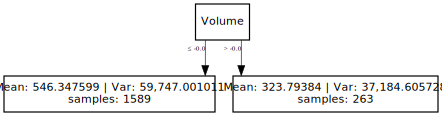

In [56]:
model[1].draw()

In [57]:
# Train a Hoeffding Tree Regressor

# Prepare the pipeline with the preprocessing steps and the model to be used
model = compose.Pipeline(
    preprocessing.StandardScaler(), # Prepare the data centered in avg 0 and std 1
    tree.HoeffdingTreeRegressor
)

metric = metrics.MSE()

# Train model with the built in function 
evaluate.progressive_val_score(getAmazonStockDataSet(dataset_path), model, metric, print_every=1000)

final_metrics_stream.append(metric.get())
models_stream.append("HT200")

[1,000] MSE: 32.712341
[2,000] MSE: 19.427222
[3,000] MSE: 15.450216
[4,000] MSE: 18.051857
[5,000] MSE: 52.514958



(process:16748): Pango-WARNING **: 15:48:52.785: couldn't load font "trebuchet Not-Rotated 11", falling back to "Sans Not-Rotated 11", expect ugly output.


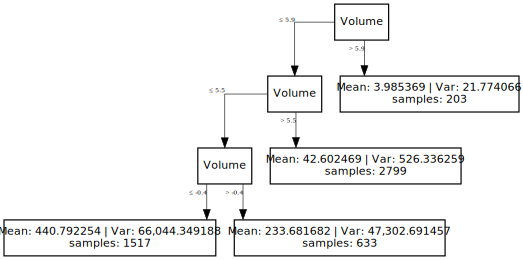

In [58]:
model[1].draw()

In [59]:
# Train a Hoeffding Tree Regressor

# Prepare the pipeline with the preprocessing steps and the model to be used
model = compose.Pipeline(
    preprocessing.StandardScaler(), # Prepare the data centered in avg 0 and std 1
    tree.HoeffdingTreeRegressor(grace_period=500)
)

metric = metrics.MSE()

# Train model with the built in function 
evaluate.progressive_val_score(getAmazonStockDataSet(dataset_path), model, metric, print_every=1000)

final_metrics_stream.append(metric.get())
models_stream.append("HT500")

[1,000] MSE: 27.776713
[2,000] MSE: 17.149601
[3,000] MSE: 14.18036
[4,000] MSE: 17.364692
[5,000] MSE: 45.093807



(process:15412): Pango-WARNING **: 15:48:53.414: couldn't load font "trebuchet Not-Rotated 11", falling back to "Sans Not-Rotated 11", expect ugly output.


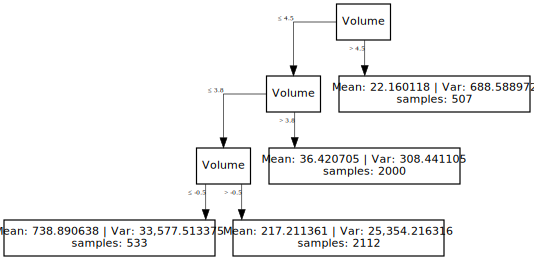

In [60]:
model[1].draw()

In [61]:
# Train a Hoeffding Tree Regressor

# Prepare the pipeline with the preprocessing steps and the model to be used
model = compose.Pipeline(
    preprocessing.StandardScaler(), # Prepare the data centered in avg 0 and std 1
    tree.HoeffdingTreeRegressor(grace_period=100)
)

metric = metrics.MSE()

# Train model with the built in function 
evaluate.progressive_val_score(getAmazonStockDataSet(dataset_path), model, metric, print_every=1000)

final_metrics_stream.append(metric.get())
models_stream.append("HT100")

[1,000] MSE: 41.658298
[2,000] MSE: 25.91612
[3,000] MSE: 21.720474
[4,000] MSE: 24.237766
[5,000] MSE: 61.043791



(process:21844): Pango-WARNING **: 15:48:54.247: couldn't load font "trebuchet Not-Rotated 11", falling back to "Sans Not-Rotated 11", expect ugly output.


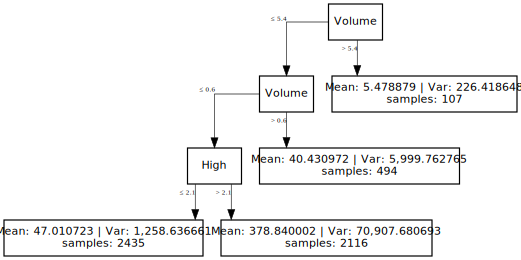

In [62]:
model[1].draw()

In [63]:
# Train a Hoeffding Tree Regressor

# Prepare the pipeline with the preprocessing steps and the model to be used
model = compose.Pipeline(
    preprocessing.StandardScaler(), # Prepare the data centered in avg 0 and std 1
    tree.HoeffdingTreeRegressor(grace_period=50)
)

metric = metrics.MSE()

# Train model with the built in function 
evaluate.progressive_val_score(getAmazonStockDataSet(dataset_path), model, metric, print_every=1000)

final_metrics_stream.append(metric.get())
models_stream.append("HT50")

[1,000] MSE: 35.924748
[2,000] MSE: 22.390414
[3,000] MSE: 18.781504
[4,000] MSE: 22.279319
[5,000] MSE: 60.130026



(process:13324): Pango-WARNING **: 15:48:55.565: couldn't load font "trebuchet Not-Rotated 11", falling back to "Sans Not-Rotated 11", expect ugly output.


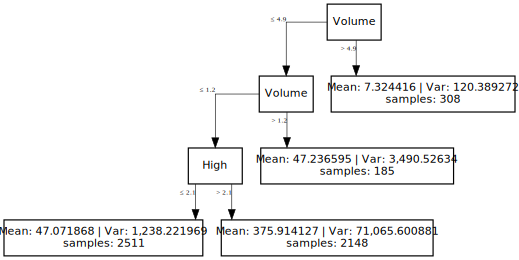

In [64]:
model[1].draw()

In [65]:
# Train a KNN Regressor

# Prepare the pipeline with the preprocessing steps and the model to be used
model = compose.Pipeline(
    preprocessing.StandardScaler(), # Prepare the data centered in avg 0 and std 1
    neighbors.KNNRegressor
)

metric = metrics.MSE()

# Train model with the built in function 
evaluate.progressive_val_score(getAmazonStockDataSet(dataset_path), model, metric, print_every=1000)

final_metrics_stream.append(metric.get())
models_stream.append("KNN")

[1,000] MSE: 480.19095
[2,000] MSE: 245.023075
[3,000] MSE: 168.642611
[4,000] MSE: 394.874653
[5,000] MSE: 3,246.411345


In [66]:
model

Pipeline (
  StandardScaler (
    with_std=True
  ),
  KNNRegressor (
    n_neighbors=5
    window_size=1000
    aggregation_method="mean"
    min_distance_keep=0.
    distance_func=functools.partial(<function minkowski_distance at 0x0000029A62EF2D40>, p=2)
  )
)

In [67]:
# Train a Random forest ensemble

# Prepare the pipeline with the preprocessing steps and the model to be used
model = compose.Pipeline(
    preprocessing.StandardScaler(), # Prepare the data centered in avg 0 and std 1
    ensemble.AdaptiveRandomForestRegressor
)

metric = metrics.MSE()

# Train model with the built in function 
evaluate.progressive_val_score(getAmazonStockDataSet(dataset_path), model, metric, print_every=1000)

final_metrics_stream.append(metric.get())
models_stream.append("RF")

[1,000] MSE: 154.927547
[2,000] MSE: 78.279925
[3,000] MSE: 58.050621
[4,000] MSE: 123.047867
[5,000] MSE: 925.301575


In [68]:
model

Pipeline (
  StandardScaler (
    with_std=True
  ),
  [ForestMemberRegressor (
    index_original=0
    model=BaseTreeRegressor (
      max_features=2
      grace_period=50
      max_depth=inf
      delta=0.01
      tau=0.05
      leaf_prediction="adaptive"
      leaf_model=LinearRegression (
        optimizer=SGD (
          lr=Constant (
            learning_rate=0.01
          )
        )
        loss=Squared ()
        l2=0.
        l1=0.
        intercept_init=0.
        intercept_lr=Constant (
          learning_rate=0.01
        )
        clip_gradient=1e+12
        initializer=Zeros ()
      )
      model_selector_decay=0.95
      nominal_attributes=None
      splitter=TEBSTSplitter (
        digits=1
      )
      min_samples_split=5
      binary_split=False
      max_size=500.
      memory_estimate_period=2000000
      stop_mem_management=False
      remove_poor_attrs=False
      merit_preprune=True
      rng=<random.Random object at 0x0000029A618229B0>
    )
    created_on=5005
    drift_detector=ADWIN (
      delta=0.001
    )
    warning_detector=ADWIN (
      delta=0.01
    )
    is_background_learner=False
    metric=MSE ()
  ), ForestMemberRegressor (
    index_original=1
    model=BaseTreeRegressor (
      max_features=2
      grace_period=50
      max_depth=inf
      delta=0.01
      tau=0.05
      leaf_prediction="adaptive"
      leaf_model=LinearRegression (
        optimizer=SGD (
          lr=Constant (
            learning_rate=0.01
          )
        )
        loss=Squared ()
        l2=0.
        l1=0.
        intercept_init=0.
        intercept_lr=Constant (
          learning_rate=0.01
        )
        clip_gradient=1e+12
        initializer=Zeros ()
      )
      model_selector_decay=0.95
      nominal_attributes=None
      splitter=TEBSTSplitter (
        digits=1
      )
      min_samples_split=5
      binary_split=False
      max_size=500.
      memory_estimate_period=2000000
      stop_mem_management=False
      remove_poor_attrs=False
      merit_preprune=True
      rng=<random.Random object at 0x0000029A618229B0>
    )
    created_on=4879
    drift_detector=ADWIN (
      delta=0.001
    )
    warning_detector=ADWIN (
      delta=0.01
    )
    is_background_learner=False
    metric=MSE ()
  ), ForestMemberRegressor (
    index_original=2
    model=BaseTreeRegressor (
      max_features=2
      grace_period=50
      max_depth=inf
      delta=0.01
      tau=0.05
      leaf_prediction="adaptive"
      leaf_model=LinearRegression (
        optimizer=SGD (
          lr=Constant (
            learning_rate=0.01
          )
        )
        loss=Squared ()
        l2=0.
        l1=0.
        intercept_init=0.
        intercept_lr=Constant (
          learning_rate=0.01
        )
        clip_gradient=1e+12
        initializer=Zeros ()
      )
      model_selector_decay=0.95
      nominal_attributes=None
      splitter=TEBSTSplitter (
        digits=1
      )
      min_samples_split=5
      binary_split=False
      max_size=500.
      memory_estimate_period=2000000
      stop_mem_management=False
      remove_poor_attrs=False
      merit_preprune=True
      rng=<random.Random object at 0x0000029A618229B0>
    )
    created_on=3147
    drift_detector=ADWIN (
      delta=0.001
    )
    warning_detector=ADWIN (
      delta=0.01
    )
    is_background_learner=False
    metric=MSE ()
  ), ForestMemberRegressor (
    index_original=3
    model=BaseTreeRegressor (
      max_features=2
      grace_period=50
      max_depth=inf
      delta=0.01
      tau=0.05
      leaf_prediction="adaptive"
      leaf_model=LinearRegression (
        optimizer=SGD (
          lr=Constant (
            learning_rate=0.01
          )
        )
        loss=Squared ()
        l2=0.
        l1=0.
        intercept_init=0.
        intercept_lr=Constant (
          learning_rate=0.01
        )
        clip_gradient=1e+12
        initializer=Zeros ()
      )
      model_selector_decay=0.95
      nominal_attributes=None
      s

In [69]:
# Train a bag of linear regression

# Prepare the pipeline with the preprocessing steps and the model to be used
model = compose.Pipeline(
    preprocessing.StandardScaler(), # Prepare the data centered in avg 0 and std 1
    ensemble.BaggingRegressor(linear_model.LinearRegression(l2=0.2))
)

metric = metrics.MSE()

# Train model with the built in function 
evaluate.progressive_val_score(getAmazonStockDataSet(dataset_path), model, metric, print_every=1000)

final_metrics_stream.append(metric.get())
models_stream.append("BagLR")

[1,000] MSE: 27.179749
[2,000] MSE: 14.485099
[3,000] MSE: 11.66354
[4,000] MSE: 14.410889
[5,000] MSE: 37.085755


In [70]:
# Train a bag of linear regression

# Prepare the pipeline with the preprocessing steps and the model to be used
model = compose.Pipeline(
    preprocessing.StandardScaler(), # Prepare the data centered in avg 0 and std 1
    ensemble.BaggingRegressor(tree.HoeffdingTreeRegressor())
)

metric = metrics.MSE()

# Train model with the built in function 
evaluate.progressive_val_score(getAmazonStockDataSet(dataset_path), model, metric, print_every=1000)

final_metrics_stream.append(metric.get())
models_stream.append("BagHT200")

[1,000] MSE: 26.532989
[2,000] MSE: 16.10219
[3,000] MSE: 13.141737
[4,000] MSE: 16.194895
[5,000] MSE: 42.612396


In [71]:
model

Pipeline (
  StandardScaler (
    with_std=True
  ),
  [HoeffdingTreeRegressor (
    grace_period=200
    max_depth=inf
    delta=1e-07
    tau=0.05
    leaf_prediction="adaptive"
    leaf_model=LinearRegression (
      optimizer=SGD (
        lr=Constant (
          learning_rate=0.01
        )
      )
      loss=Squared ()
      l2=0.
      l1=0.
      intercept_init=0.
      intercept_lr=Constant (
        learning_rate=0.01
      )
      clip_gradient=1e+12
      initializer=Zeros ()
    )
    model_selector_decay=0.95
    nominal_attributes=None
    splitter=TEBSTSplitter (
      digits=1
    )
    min_samples_split=5
    binary_split=False
    max_size=500.
    memory_estimate_period=1000000
    stop_mem_management=False
    remove_poor_attrs=False
    merit_preprune=True
  ), HoeffdingTreeRegressor (
    grace_period=200
    max_depth=inf
    delta=1e-07
    tau=0.05
    leaf_prediction="adaptive"
    leaf_model=LinearRegression (
      optimizer=SGD (
        lr=Constant (
          learning_rate=0.01
        )
      )
      loss=Squared ()
      l2=0.
      l1=0.
      intercept_init=0.
      intercept_lr=Constant (
        learning_rate=0.01
      )
      clip_gradient=1e+12
      initializer=Zeros ()
    )
    model_selector_decay=0.95
    nominal_attributes=None
    splitter=TEBSTSplitter (
      digits=1
    )
    min_samples_split=5
    binary_split=False
    max_size=500.
    memory_estimate_period=1000000
    stop_mem_management=False
    remove_poor_attrs=False
    merit_preprune=True
  ), HoeffdingTreeRegressor (
    grace_period=200
    max_depth=inf
    delta=1e-07
    tau=0.05
    leaf_prediction="adaptive"
    leaf_model=LinearRegression (
      optimizer=SGD (
        lr=Constant (
          learning_rate=0.01
        )
      )
      loss=Squared ()
      l2=0.
      l1=0.
      intercept_init=0.
      intercept_lr=Constant (
        learning_rate=0.01
      )
      clip_gradient=1e+12
      initializer=Zeros ()
    )
    model_selector_decay=0.95
    nominal_attributes=None
    splitter=TEBSTSplitter (
      digits=1
    )
    min_samples_split=5
    binary_split=False
    max_size=500.
    memory_estimate_period=1000000
    stop_mem_management=False
    remove_poor_attrs=False
    merit_preprune=True
  ), HoeffdingTreeRegressor (
    grace_period=200
    max_depth=inf
    delta=1e-07
    tau=0.05
    leaf_prediction="adaptive"
    leaf_model=LinearRegression (
      optimizer=SGD (
        lr=Constant (
          learning_rate=0.01
        )
      )
      loss=Squared ()
      l2=0.
      l1=0.
      intercept_init=0.
      intercept_lr=Constant (
        learning_rate=0.01
      )
      clip_gradient=1e+12
      initializer=Zeros ()
    )
    model_selector_decay=0.95
    nominal_attributes=None
    splitter=TEBSTSplitter (
      digits=1
    )
    min_samples_split=5
    binary_split=False
    max_size=500.
    memory_estimate_period=1000000
    stop_mem_management=False
    remove_poor_attrs=False
    merit_preprune=True
  ), HoeffdingTreeRegressor (
    grace_period=200
    max_depth=inf
    delta=1e-07
    tau=0.05
    leaf_prediction="adaptive"
    leaf_model=LinearRegression (
      optimizer=SGD (
        lr=Constant (
          learning_rate=0.01
        )
      )
      loss=Squared ()
      l2=0.
      l1=0.
      intercept_init=0.
      intercept_lr=Constant (
        learning_rate=0.01
      )
      clip_gradient=1e+12
      initializer=Zeros ()
    )
    model_selector_decay=0.95
    nominal_attributes=None
    splitter=TEBSTSplitter (
      digits=1
    )
    min_samples_split=5
    binary_split=False
    max_size=500.
    memory_estimate_period=1000000
    stop_mem_management=False
    remove_poor_attrs=False
    merit_preprune=True
  ), HoeffdingTreeRegressor (
    grace_period=200
    max_depth=inf
    delta=1e-07
    tau=0.05
    leaf_prediction="adaptive"
    leaf_model=LinearRegression (
      optimizer=SGD (
        lr=Constant (
          learning_rate=0.01
        )
      )
     

## Results

Results for the concept drift section for the features, target and metrics from a basic model

| X | Adwin | KSWIN | PageHinkley |
| --- | --- | --- | --- |
| Open | 67 | 49 | 144 |
| High | 67 | 49 | 144 |
| Low | 65 | 49 | 145 |
| Close | 63 | 49 | 144 |
| Volume | 14 | 30 | 171 |
| Close_next | 65 | 49 | 144 |
| MSE | 38 | 51 | 39 |

Next we will plot the metrics of the trained models that we been storing in lists in the previous sections of the notebook. First for each type (batch and stream) we will show all the results and then only the best of each model to show a clearer bar graph. To select the best models, a threshold of 4.2 have been set to measure against the MSE metrics.
Finally, we add a plot showing both the best batch and stream models so an easy comparison between them can be made.

Below each graph the exact value of each model is display.

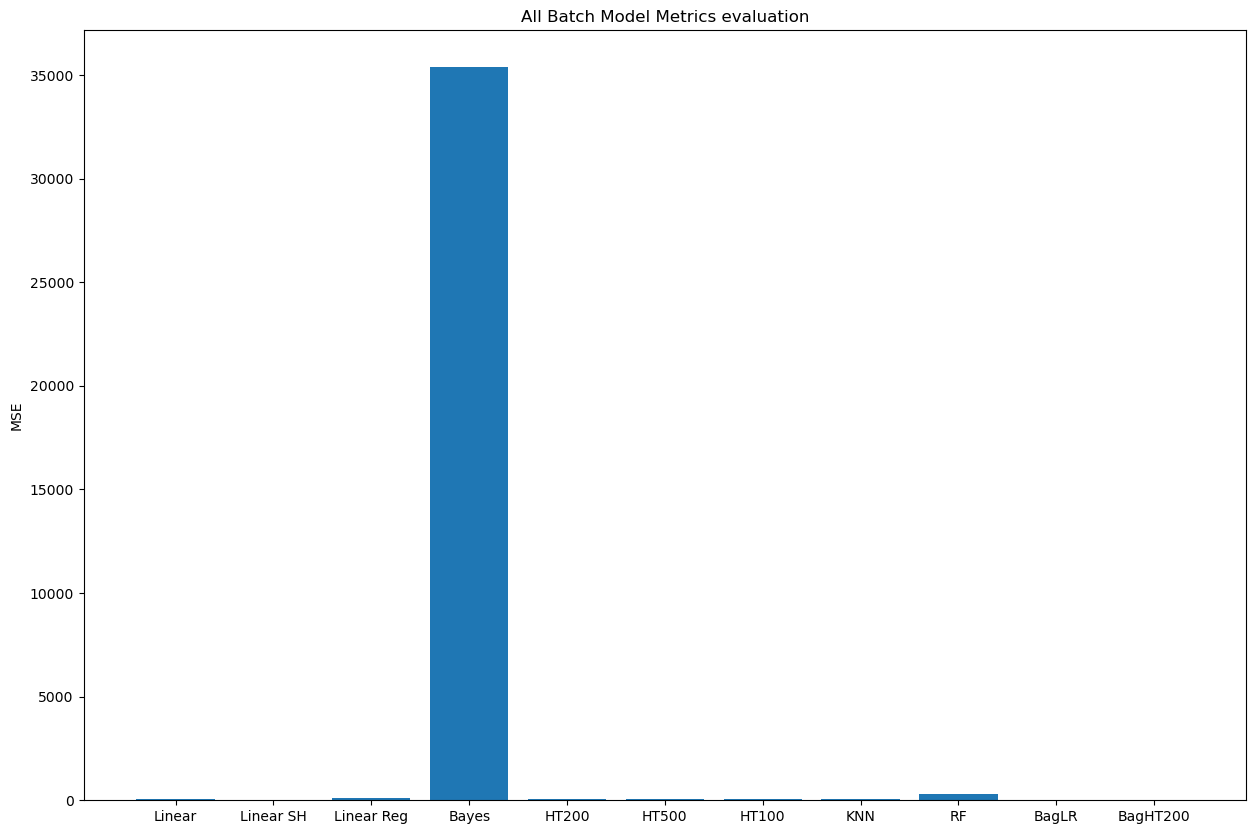

Linear 37.825640676194936

Linear SH 36.85696590151834

Linear Reg 88.80991478009278

Bayes 35394.31084040752

HT200 37.825640676194936

HT500 37.825640676194936

HT100 37.825640676194936

KNN 85.48072465331099

RF 279.58914764163785

BagLR 36.19941455920188

BagHT200 35.414199432745924

In [72]:
plt.bar(models_batch,final_metrics_batch)
plt.title('All Batch Model Metrics evaluation')
plt.ylabel('MSE')
plt.show()

for i in range(0,len(final_metrics_batch)):
    print(models_batch[i], final_metrics_batch[i])

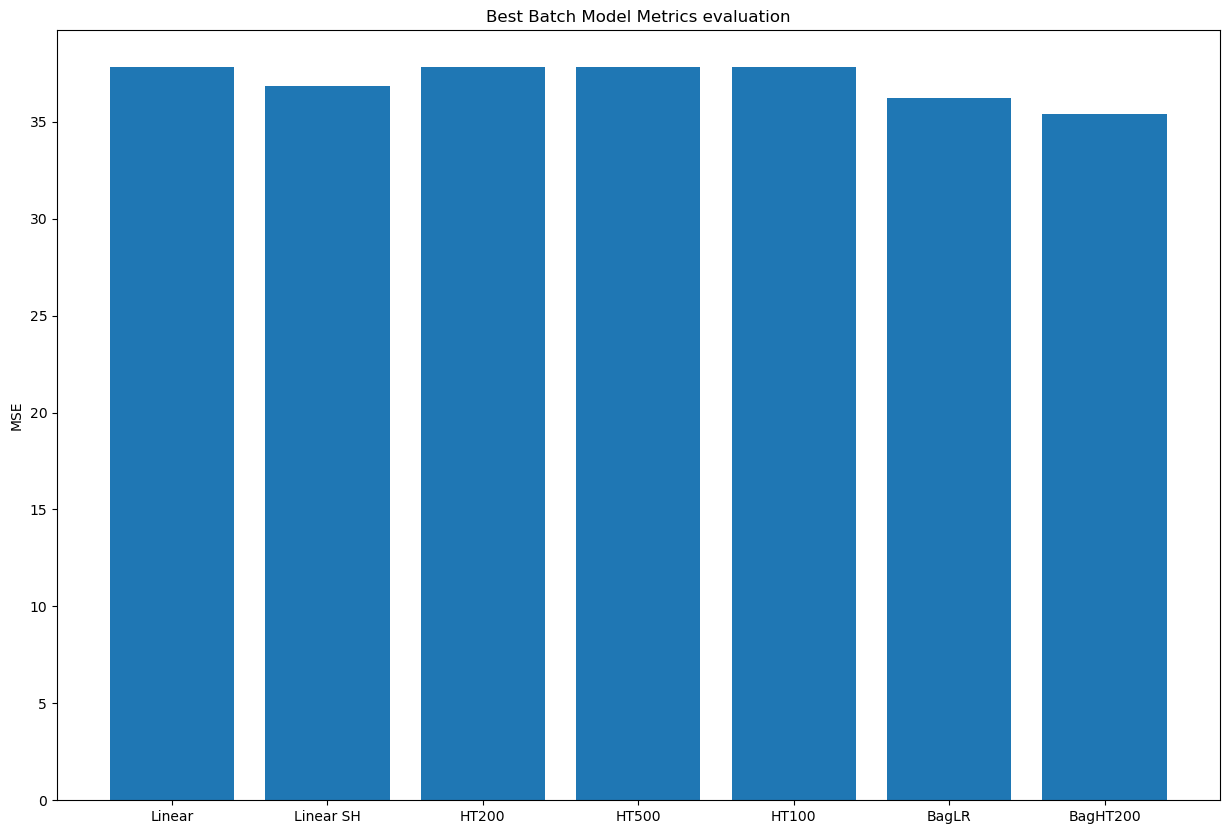

Linear 37.825640676194936

Linear SH 36.85696590151834

HT200 37.825640676194936

HT500 37.825640676194936

HT100 37.825640676194936

BagLR 36.19941455920188

BagHT200 35.414199432745924

In [73]:
best_models_batch = []
best_final_metrics_batch = []

for i in range(0,len(final_metrics_batch)):
    if (final_metrics_batch[i] < 40):
        best_models_batch.append(models_batch[i])
        best_final_metrics_batch.append(final_metrics_batch[i])

plt.bar(best_models_batch,best_final_metrics_batch)
plt.title('Best Batch Model Metrics evaluation')
plt.ylabel('MSE')
plt.show()

for i in range(0,len(best_final_metrics_batch)):
    print(best_models_batch[i], best_final_metrics_batch[i])

Use the test set for batch with the best models (bagging Linear Regression and HoeffdingTreeRegressor)

In [74]:
ev_models_batch = ["BagLR tst","BagHT200 tst"]
ev_metrics_batch = []

# Train a Linear Regression using scaler
model = Pipeline(
       ('scale', preprocessing.StandardScaler()),
        ('ml_model', ensemble.BaggingRegressor(linear_model.LinearRegression()))
    )
    
# This function returns an object of type SKLRegressorWrapper 
# which is compatible with the signature of sklearn
model = convert_river_to_sklearn(model)

model.fit(x_train,y_train)
y_pred = model.predict(x_test)
ev = mean_squared_error(y_test, y_pred)

print("Evaluation of Bagging Linear regression:", ev)

ev_metrics_batch.append(ev)

# Train a Linear Regression using scaler
model = Pipeline(
       ('scale', preprocessing.StandardScaler()),
        ('ml_model', ensemble.BaggingRegressor(tree.HoeffdingTreeRegressor()))
    )
    
# This function returns an object of type SKLRegressorWrapper 
# which is compatible with the signature of sklearn
model = convert_river_to_sklearn(model)

model.fit(x_train,y_train)
y_pred = model.predict(x_test)
ev = mean_squared_error(y_test, y_pred)

print("Evaluation of Bagging Hoeffding Tree regression:", ev)

ev_metrics_batch.append(ev)

Evaluation of Bagging Linear regression: 29.423877745979198

Evaluation of Bagging Hoeffding Tree regression: 30.81686361360981

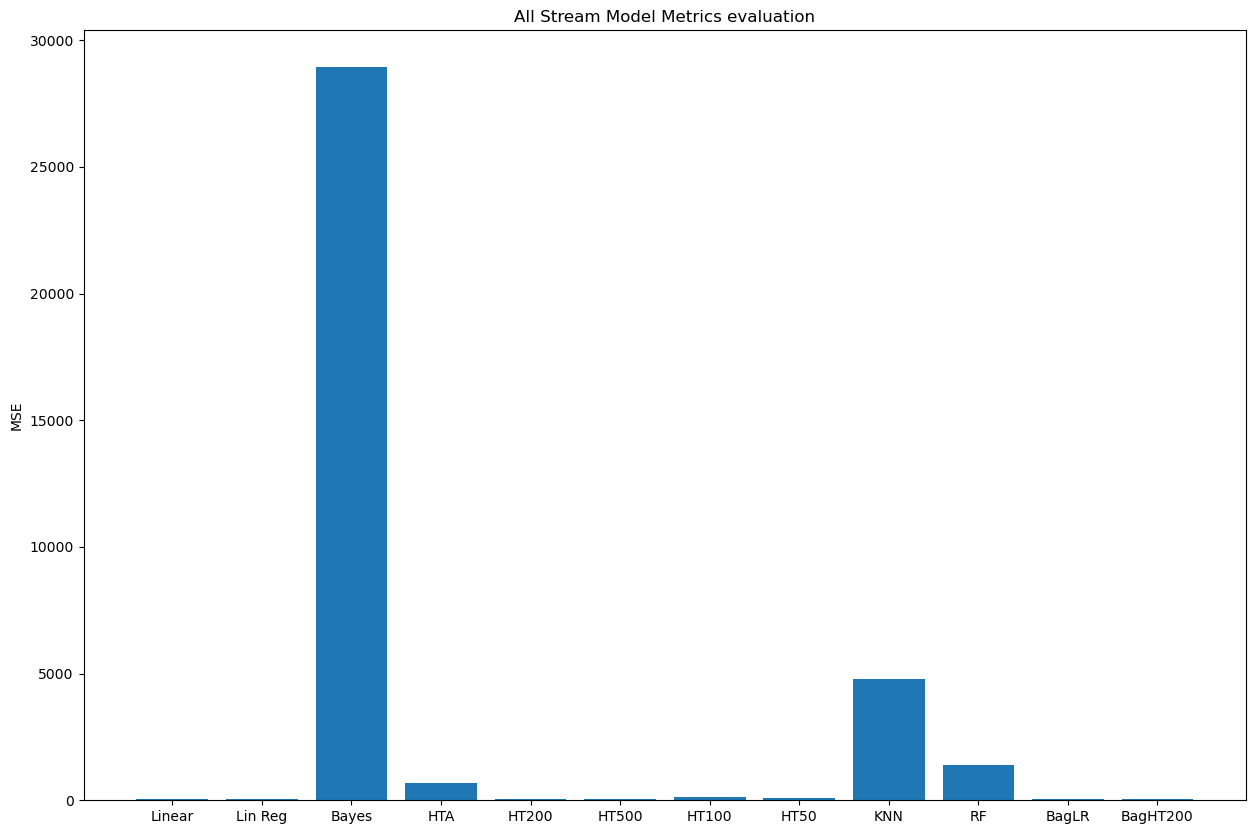

Linear 56.54959759873554

Lin Reg 52.22937602418341

Bayes 28943.21033226482

HTA 698.4430081709515

HT200 64.98074779740018

HT500 56.45693676999895

HT100 117.33100780200597

HT50 70.42234908187207

KNN 4791.1326005471265

RF 1410.8755013454652

BagLR 47.34297523078211

BagHT200 50.524402592178966

In [75]:
plt.bar(models_stream,final_metrics_stream)
plt.title('All Stream Model Metrics evaluation')
plt.ylabel('MSE')
plt.show()

for i in range(0,len(final_metrics_stream)):
    print(models_stream[i], final_metrics_stream[i])

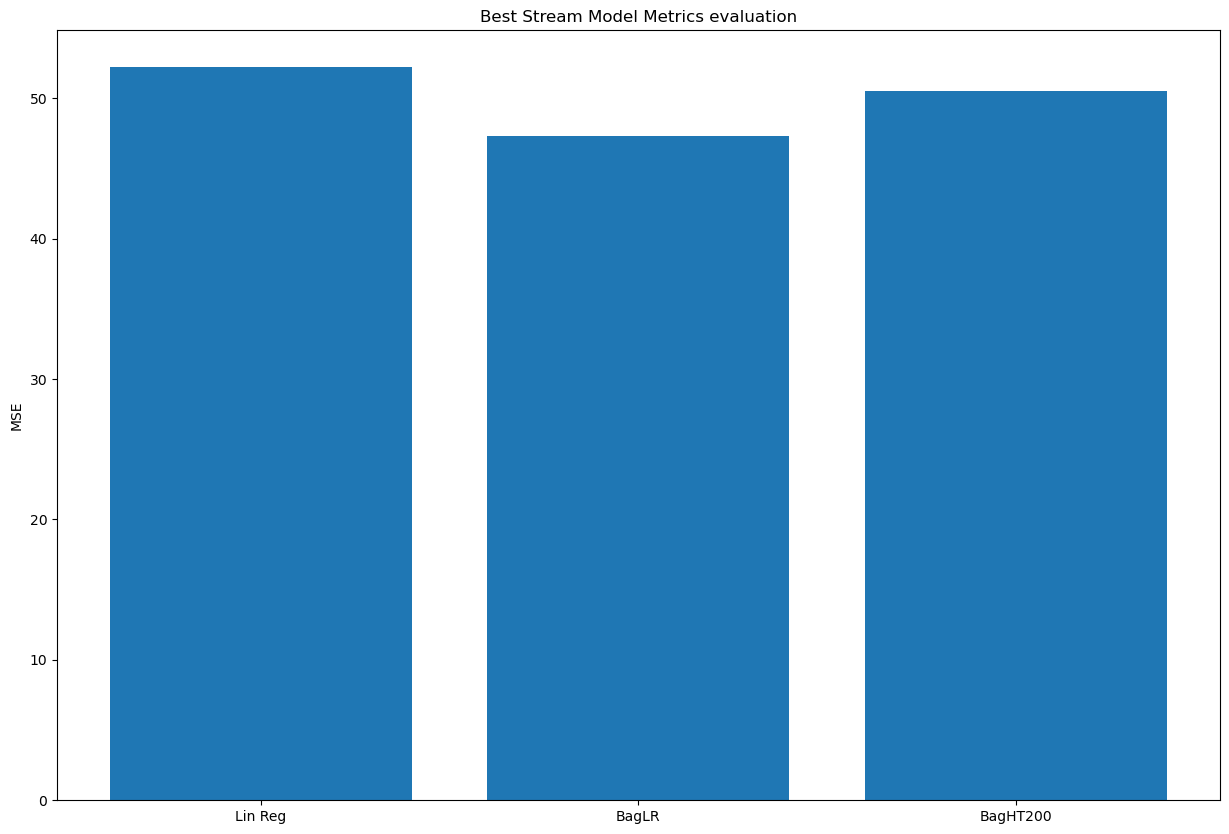

Lin Reg 52.22937602418341

BagLR 47.34297523078211

BagHT200 50.524402592178966

In [76]:
best_models_stream = []
best_final_metrics_stream = []

for i in range(0,len(final_metrics_stream)):
    if (final_metrics_stream[i] < 55):
        best_models_stream.append(models_stream[i])
        best_final_metrics_stream.append(final_metrics_stream[i])

plt.bar(best_models_stream,best_final_metrics_stream)
plt.title('Best Stream Model Metrics evaluation')
plt.ylabel('MSE')
plt.show()

for i in range(0,len(best_final_metrics_stream)):
    print(best_models_stream[i], best_final_metrics_stream[i])

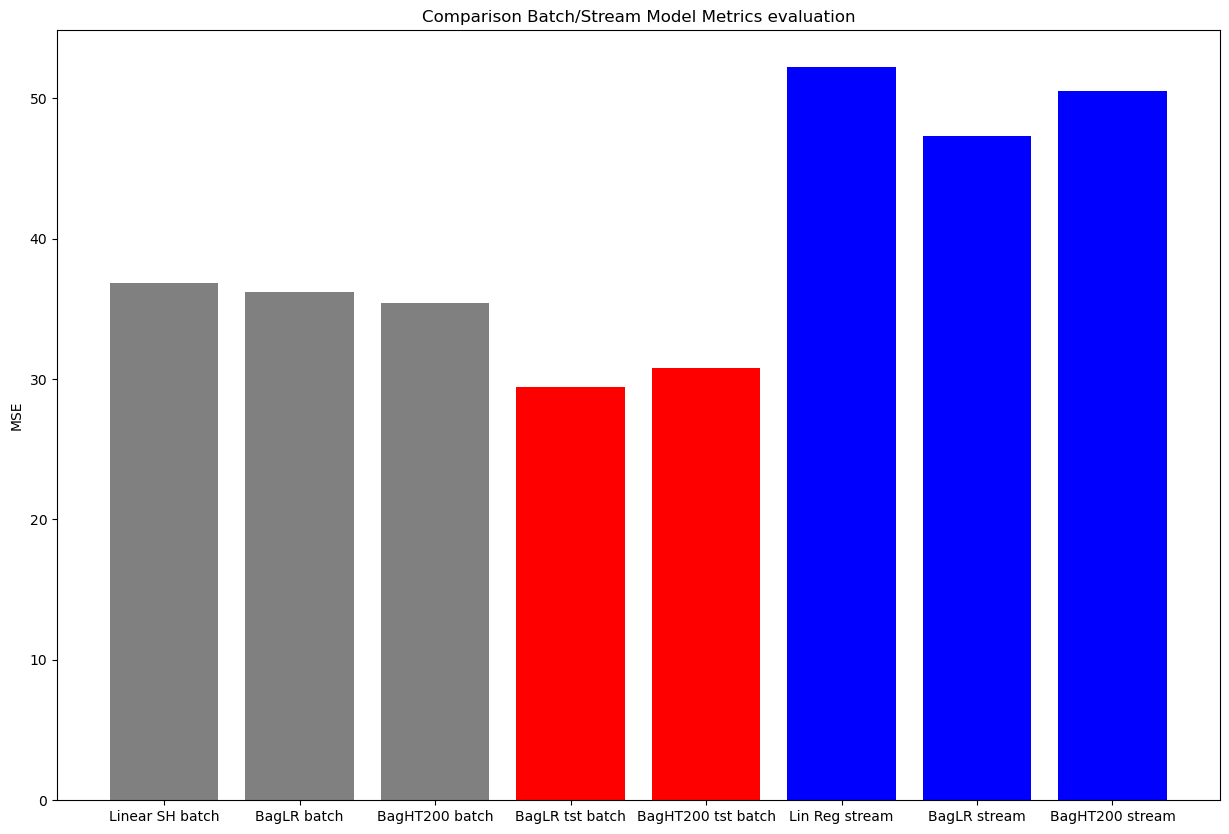

Linear SH batch 36.85696590151834

BagLR batch 36.19941455920188

BagHT200 batch 35.414199432745924

BagLR tst batch 29.423877745979198

BagHT200 tst batch 30.81686361360981

Lin Reg stream 52.22937602418341

BagLR stream 47.34297523078211

BagHT200 stream 50.524402592178966

In [77]:
comparison_models = []
comparison_models_metrics = []
comparison_models_color = []

# Add the CV of batch
for i in range(0,len(best_final_metrics_batch)):
    if (best_final_metrics_batch[i] < 37):
        comparison_models.append(best_models_batch[i] + " batch")
        comparison_models_metrics.append(best_final_metrics_batch[i])
        comparison_models_color.append('grey')

# Add the evaluation of batch
for i in range(0,len(ev_metrics_batch)):
    comparison_models.append(ev_models_batch[i] + " batch")
    comparison_models_metrics.append(ev_metrics_batch[i])
    comparison_models_color.append('red')

# Add the streams
for i in range(0,len(best_final_metrics_stream)):
    comparison_models.append(best_models_stream[i] + " stream")
    comparison_models_metrics.append(best_final_metrics_stream[i])
    comparison_models_color.append('blue')

plt.bar(comparison_models,comparison_models_metrics, color = comparison_models_color)
plt.title('Comparison Batch/Stream Model Metrics evaluation')
plt.ylabel('MSE')
plt.show()

for i in range(0,len(comparison_models)):
    print(comparison_models[i], comparison_models_metrics[i])

## Extra testings for support conclusions

#### Drift retraining

In [78]:
# Test with retraining in drift detection for metric with threshold. Use MAE as metric.
drift_detector = drift.ADWIN(delta=0.002)

# Train a Linear Regression using scaler

# Prepare the pipeline with the preprocessing steps and the model to be used
model = compose.Pipeline(
    preprocessing.StandardScaler(), # Prepare the data centered in avg 0 and std 1
    linear_model.LinearRegression()
)
metric = metrics.MAE()

count = 0
for sample, target in getAmazonStockDataSet(dataset_path):
    target_prediction = model.predict_one(sample)
    
    model.learn_one(sample, float(target))
    metric.update(target, target_prediction)
    
    if (count % 1500==0):
        print(sample, target, target_prediction)
    count = count + 1

    drift_detector.update(metric.get())

    if drift_detector.drift_detected:
        print(f'Change detected at index {count} Metric of the model {metric}. Metric of the drift {drift_detector.estimation}')
        # If drift detection surpasses a threshold, start learning again
        if (drift_detector.estimation > 3.8):
            print("RETRAINING MODEL")
            # Restart model and metrics
            model = compose.Pipeline(
                preprocessing.StandardScaler(), # Prepare the data centered in avg 0 and std 1
                linear_model.LinearRegression()
            )
            metric = metrics.MAE()
            # According river documentation, this could be done, but grace period parameter does not work
            # drift_detector = drift.ADWIN(delta=0.002, grace_period = 100)
            drift_detector = drift.ADWIN()

print(sample, target, target_prediction)
print(metric)

{'Open': 1.97, 'High': 1.98, 'Low': 1.71, 'Close': 1.73, 'Volume': 14700000}
1.71 0.0

Change detected at index 128 Metric of the model MAE: 0.558458. Metric of the drift 0.7273399317633881

Change detected at index 416 Metric of the model MAE: 1.061976. Metric of the drift 0.6511215338542028

Change detected at index 544 Metric of the model MAE: 1.936073. Metric of the drift 1.627042190412882

Change detected at index 736 Metric of the model MAE: 2.747678. Metric of the drift 2.406003200066725

Change detected at index 864 Metric of the model MAE: 3.578625. Metric of the drift 3.2331083795082143

Change detected at index 1152 Metric of the model MAE: 3.386105. Metric of the drift 3.570316669648398

Change detected at index 1408 Metric of the model MAE: 3.028037. Metric of the drift 3.16229506145748

{'Open': 31.55, 'High': 33.49, 'Low': 31.44, 'Close': 32.95, 'Volume': 15887753}
32.6 39.48668692900812

Change detected at index 1920 Metric of the model MAE: 2.83685. Metric of the drift 2.96176812200831

Change detected at index 2368 Metric of the model MAE: 2.595594. Metric of the drift 2.687512327365555

{'Open': 82.57, 'High': 85.35, 'Low': 82.4, 'Close': 82.4, 'Volume': 7923169}
79.79 83.25833784195495

Change detected at index 3168 Metric of the model MAE: 2.477766. Metric of the drift 2.4894721853961324

Change detected at index 3712 Metric of the model MAE: 2.662349. Metric of the drift 2.5372720273081364

Change detected at index 4192 Metric of the model MAE: 2.864339. Metric of the drift 2.7569313008833083

{'Open': 383.51, 'High': 387.81, 'Low': 381.21, 'Close': 385.11, 'Volume': 2583500}
383.45 385.4303214240416

Change detected at index 4608 Metric of the model MAE: 3.253252. Metric of the drift 3.072294819555455

Change detected at index 4832 Metric of the model MAE: 3.668774. Metric of the drift 3.5293968498836708

Change detected at index 5088 Metric of the model MAE: 4.039493. Metric of the drift 3.865641275496741

RETRAINING MODEL

Change detected at index 5120 Metric of the model MAE: 720.538689. Metric of the drift 792.7606928178351

RETRAINING MODEL

{'Open': 1125.96, 'High': 1129.62, 'Low': 1115.77, 'Close': 1129.13, 'Volume': 3729978}
1125.35 993.6785979737467

MAE: 474.027102

In [79]:
# Test with retraining in drift detection for target with threshold. Use MAE as metric.
drift_detector = drift.ADWIN()

# Train a Linear Regression using scaler

# Prepare the pipeline with the preprocessing steps and the model to be used
model = compose.Pipeline(
    preprocessing.StandardScaler(), # Prepare the data centered in avg 0 and std 1
    linear_model.LinearRegression()
)
metric = metrics.MAE()

count = 0
for sample, target in getAmazonStockDataSet(dataset_path):
    drift_detector.update(target)

    if drift_detector.drift_detected:
        # If drift detection surpases a threshold, start learning again
        if (drift_detector.estimation > 600):
            print("RETRAINING MODEL")
            print(f'Change detected at index {count} Metric of the model {metric}. Metric of the drift {drift_detector.estimation}')

            model = compose.Pipeline(
                preprocessing.StandardScaler(), # Prepare the data centered in avg 0 and std 1
                linear_model.LinearRegression()
            )
            metric = metrics.MAE()
            # According river documentation, this could be done, but grace period parameter does not work
            # drift_detector = drift.ADWIN(delta=0.002, grace_period = 100)
            drift_detector = drift.ADWIN()

    target_prediction = model.predict_one(sample)
    
    model.learn_one(sample, float(target))
    metric.update(target, target_prediction)
    
    if (count % 1500==0):
        print(sample, target, target_prediction)
    count = count + 1

print(sample, target, target_prediction)
print(metric)

{'Open': 1.97, 'High': 1.98, 'Low': 1.71, 'Close': 1.73, 'Volume': 14700000}
1.71 0.0

{'Open': 31.55, 'High': 33.49, 'Low': 31.44, 'Close': 32.95, 'Volume': 15887753}
32.6 39.48668692900812

{'Open': 82.57, 'High': 85.35, 'Low': 82.4, 'Close': 82.4, 'Volume': 7923169}
79.79 83.25833784195495

{'Open': 383.51, 'High': 387.81, 'Low': 381.21, 'Close': 385.11, 'Volume': 2583500}
383.45 385.4303214240416

RETRAINING MODEL

Change detected at index 4671 Metric of the model MAE: 3.38995. Metric of the drift 633.6133333333335

RETRAINING MODEL

Change detected at index 4799 Metric of the model MAE: 199.762683. Metric of the drift 686.4889583333334

RETRAINING MODEL

Change detected at index 4863 Metric of the model MAE: 246.677269. Metric of the drift 762.711041666667

RETRAINING MODEL

Change detected at index 4927 Metric of the model MAE: 356.582622. Metric of the drift 776.1521875000003

RETRAINING MODEL

Change detected at index 4991 Metric of the model MAE: 248.480458. Metric of the drift 838.8293749999995

RETRAINING MODEL

Change detected at index 5055 Metric of the model MAE: 244.540245. Metric of the drift 966.2839583333331

RETRAINING MODEL

Change detected at index 5119 Metric of the model MAE: 486.815134. Metric of the drift 979.5070833333331

{'Open': 1125.96, 'High': 1129.62, 'Low': 1115.77, 'Close': 1129.13, 'Volume': 3729978}
1125.35 987.6265936779081

MAE: 437.485226

#### Time series

In [80]:
# Train a Time series
metric = time_series.evaluate(
    dataset= getAmazonStockDataSet(dataset_path),
    model=time_series.HoltWinters(alpha=0.1),
    metric=metrics.MSE(),
    #agg_func=statistics.mean,
    horizon=5
)

metric

+1 MSE: 160.124198
+2 MSE: 186.4933
+3 MSE: 213.044646
+4 MSE: 239.473296
+5 MSE: 266.021275

#### Use of average values

In [81]:
from river import feature_extraction, utils, stats

# Train a Linear Regression using scaler. Add target agg, maybe useful for more than one stock or day

# Prepare the pipeline with the preprocessing steps and the model to be used
model = compose.Pipeline(
    preprocessing.StandardScaler(), # Prepare the data centered in avg 0 and std 1
        compose.TransformerUnion(
        feature_extraction.Agg(on='Close', by='Close', how=utils.Rolling(stats.Mean(), 5)),
        feature_extraction.Agg(on='Close', by='Close', how=utils.Rolling(stats.Mean(), 10)),
        feature_extraction.Agg(on='Close', by='Close', how=utils.Rolling(stats.Mean(), 15))
    ),
    linear_model.LinearRegression()
)
metric = metrics.MSE()

# Train model with the built in function 
evaluate.progressive_val_score(getAmazonStockDataSet(dataset_path), model, metric, print_every=1000)

[1,000] MSE: 17.849088
[2,000] MSE: 12.647321
[3,000] MSE: 12.102961
[4,000] MSE: 14.25959
[5,000] MSE: 33.423669


MSE: 40.934935